## Домашнее задание Numpy Neural Net Exploration (50 баллов)

В этом домашнем задании требуется провести набор экспериментов с нейронной сетью. Для проведения экспериментов нужно доработать представленный фреймворк для обучения нейронной сети на Numpy в проекте **Numpy_NN** c **hinge_loss** функцией ошибки. 

Ссылка на проект - https://github.com/runnerup96/Numpy-NN-Framework

Все необходимые доработки обозначены в проекте тегом **TODO**.

В ноутбуке только сами эксперименты с помощью данных команд - все доработки делать внутри фреймворка.

**Ссылка на версию проекта со всеми необходимыми доработками:**  
https://github.com/DmitryInd/Numpy-NN-Framework

In [1]:
# Пример импорта модуля
import os
import sys
sys.path.append(os.path.join(os.getcwd(), "src"))

from nn.module import sequential

# пример быстрой перезагрузки модуля без рестарта ноутбука
import importlib
importlib.reload(sequential)

<module 'nn.module.sequential' from '/home/dmitryindenbom/Documents/PyProjects/Numpy-NN-Framework/src/nn/module/sequential.py'>

Вам нужно провести набор экспериментов с CIFAR датасетом и исследовать поведение нейронной сети на этом датасете при разных архитектурах. Пример 1ого эксперимента можно найти в ноутбуке **test_CIFAR_training.py**

Ваши эксперименты должы быть логичны - старайтесь последовательно строить архитектуру и попытайтесь к концу эксприментов определить комбинацию компонент нейронной сети для лучшего качества. Также же вы можете расширять количеcтво экспериментов, подтверждая это соответсвующими выводами. 

В каждом эксперименте должен быть:
    
* Процесс обучения нейронной сети с помощью training.train.train
* Проверка градиента для каждой архитектуры нейронной сети с помощью utils.gradient_check(если это указано в описании эксперимента)
* Визуализация обучения - воспользоваться методом visualization_utils.plot_learning_curves
* Расчет точности общей точности модели и расчет по классовой точности с помощью sklearn.metrics.classification_report
* Ваш вывод по результату эксперимента
    
В каждом эксперименте должен быть каждый пункт иначе эксперимент не оценивается. Каждый эксперимент оценивается в **4 балла**. За расширение пространства экспериментов и реализации своих идей можно дополнительно получить до **6 баллов**.

В данном ДЗ оценивается качество работы доработанного вами фреймворка, качество проведения эксперимента и полученный результат. 

### Перед началом экспериментов скачаем и предобработаем набор данных.  
(Следующие ячейки скопированы из test_CIFAR_training.ipynb).

In [2]:
import glob
import pickle
import numpy as np

Загрузим датасет

In [3]:
# import wget
# wget.download("https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz")

И распакуем его

In [4]:
# !tar -xzf cifar-10-python.tar.gz

На выходе будем иметь следующие файлы

In [5]:
files = glob.glob("cifar-10-batches-py/**")
files = [item.split('/')[-1] for item in files]
for file in sorted(files):
    print(f"-{file}")

-batches.meta
-data_batch_1
-data_batch_2
-data_batch_3
-data_batch_4
-data_batch_5
-readme.html
-test_batch


Из этих файлов нас интересуют data_batch_1, data_batch_2, ..., data_batch_5 -- это файлы с тренировочными данными, и файл test_batch -- это файл с тестовыми данными, на которых мы будем измерять свои метрики.

Посмотрим ближе на структуру файлов

In [6]:
with open("cifar-10-batches-py/data_batch_1", "rb") as f:
    train_dataset_1 = pickle.load(f, encoding="bytes")

Датасет содержит следующие ключи:

In [7]:
for key in train_dataset_1.keys():
    print(f"-{key.decode('utf-8')}")

-batch_label
-labels
-data
-filenames


Ключ `batch_label` нас не интересует, так как содержит только лишь информацию о номере бача

In [8]:
train_dataset_1[b'batch_label'].decode('utf-8')

'training batch 1 of 5'

Ключ `filenames` в данном случае нас тоже не интересует, так как он содержит названия файлов, которые мы без привлечения языковых моделей использовать не сможем

In [9]:
print("Первые 10 названий:")
for name in train_dataset_1[b'filenames'][:10]:
    print(f"-{name.decode('utf-8')}")

Первые 10 названий:
-leptodactylus_pentadactylus_s_000004.png
-camion_s_000148.png
-tipper_truck_s_001250.png
-american_elk_s_001521.png
-station_wagon_s_000293.png
-coupe_s_001735.png
-cassowary_s_001300.png
-cow_pony_s_001168.png
-sea_boat_s_001584.png
-tabby_s_001355.png


Остаются два наиболее интересных ключа, это `data` и `labels`.

Как нетрудно догадаться, `labels` содержит классы. Выведем первые 10 элементов:

In [10]:
print(train_dataset_1[b'labels'][:10])

[6, 9, 9, 4, 1, 1, 2, 7, 8, 3]


Классы представлены числовыми метками. В принципе нам нет необходимости знать соответствие между ними, однако эти данные можно найти в файле `batches.meta`:

In [11]:
with open("cifar-10-batches-py/batches.meta", "rb") as f:
    classes_names = pickle.load(f, encoding="bytes")

for ind, name in enumerate(classes_names[b'label_names']):
    print(f"{ind}: {name.decode('utf-8')}")

0: airplane
1: automobile
2: bird
3: cat
4: deer
5: dog
6: frog
7: horse
8: ship
9: truck


Ключ `data` содержит уже сами числовые данные

In [12]:
print(f"Количество данных: {len(train_dataset_1[b'data'])}")
print(f"Размер вектора: {train_dataset_1[b'data'][0].shape}")

Количество данных: 10000
Размер вектора: (3072,)


Теперь интересно посмотреть на сбалансированность меток по разбиениям. Для этого загрузим все тестовые разбиения

In [13]:
with open("cifar-10-batches-py/data_batch_2", "rb") as f:
    train_dataset_2 = pickle.load(f, encoding="bytes")

with open("cifar-10-batches-py/data_batch_3", "rb") as f:
    train_dataset_3 = pickle.load(f, encoding="bytes")

with open("cifar-10-batches-py/data_batch_4", "rb") as f:
    train_dataset_4 = pickle.load(f, encoding="bytes")

with open("cifar-10-batches-py/data_batch_5", "rb") as f:
    train_dataset_5 = pickle.load(f, encoding="bytes")

И посчитаем сколько раз каждая метка встречается в каждом датасете

In [14]:
datasets = [train_dataset_1, train_dataset_2, train_dataset_3, 
            train_dataset_4, train_dataset_5]

labels = list(range(10))

print("|=====|{}|{}|{}|{}|{}|{}|".format(
    "=" * 6, "=" * 6, "=" * 6, "=" * 6, "=" * 6, "=" * 6))
print("|Label|{0:^{1}}|{2:^{3}}|{4:^{5}}|{6:^{7}}|{8:^{9}}|{10:^{11}}|".format(
    "Data 1", 6, "Data 2", 6, "Data 3", 6, "Data 4", 6, "Data 5", 6, "Sum", 6))
print("|=====|{}|{}|{}|{}|{}|{}|".format(
    "=" * 6, "=" * 6, "=" * 6, "=" * 6, "=" * 6, "=" * 6))

for label in labels:
    print("|{0:^{1}}|".format(label, 5), end='')
    label_num = 0
    for dataset in datasets:
        print("{0:^{1}}|".format(dataset[b'labels'].count(label), 6), end='')
        label_num += dataset[b'labels'].count(label)
    print("{0:^{1}}|".format(label_num, 6))

print("|=====|{}|{}|{}|{}|{}|{}|".format(
    "=" * 6, "=" * 6, "=" * 6, "=" * 6, "=" * 6, "=" * 6))

|=====|======|======|======|======|======|======|
|Label|Data 1|Data 2|Data 3|Data 4|Data 5| Sum  |
|=====|======|======|======|======|======|======|
|  0  | 1005 | 984  | 994  | 1003 | 1014 | 5000 |
|  1  | 974  | 1007 | 1042 | 963  | 1014 | 5000 |
|  2  | 1032 | 1010 | 965  | 1041 | 952  | 5000 |
|  3  | 1016 | 995  | 997  | 976  | 1016 | 5000 |
|  4  | 999  | 1010 | 990  | 1004 | 997  | 5000 |
|  5  | 937  | 988  | 1029 | 1021 | 1025 | 5000 |
|  6  | 1030 | 1008 | 978  | 1004 | 980  | 5000 |
|  7  | 1001 | 1026 | 1015 | 981  | 977  | 5000 |
|  8  | 1025 | 987  | 961  | 1024 | 1003 | 5000 |
|  9  | 981  | 985  | 1029 | 983  | 1022 | 5000 |
|=====|======|======|======|======|======|======|


Как видим, данные не сбалансированы по разбиениям, поэтому объединим все в один датасет и разобьем это на два датасета, тренировочный и валидационный, при этом сразу поделим значения каждого вектора на 256, чтобы иметь интенсивность в относительных единицах (хотя максимум на 255)

In [15]:
train_dataset = []

for dataset in datasets:
    for vec, label in zip(dataset[b'data'], dataset[b'labels']):
        train_dataset.append((vec / 256, label))

На валидационную выборку оставим 10000 элементов, по 1000 примеров из каждого класса, выбранных случайно

In [16]:
np.random.seed(42)
np.random.shuffle(train_dataset)

train_data = []
valid_data = []

cnt = {ind: 0 for ind in range(10)}

for vec, label in train_dataset:
    if cnt[label] < 1000:
        cnt[label] += 1
        valid_data.append((vec, label))
    else:
        train_data.append((vec, label))

Подготовим еще тестовый датасет

In [17]:
with open("cifar-10-batches-py/test_batch", "rb") as f:
    test_dataset = pickle.load(f, encoding="bytes")

test_data = []
for vec, label in zip(test_dataset[b'data'], test_dataset[b'labels']):
    test_data.append((vec / 256, label))

Посмотрим на статистики

In [18]:
print("|=====|{}|{}|{}|{}|".format("=" * 6, "=" * 6, "=" * 6, "=" * 6))
print("|Label|{0:^{1}}|{2:^{3}}|{4:^{5}}|{6:^{7}}|".format(
    "Train", 6, "Valid", 6, "Test", 6, "Sum", 6))
print("|=====|{}|{}|{}|{}|".format("=" * 6, "=" * 6, "=" * 6, "=" * 6))

labels = list(range(10))
for label in labels:
    print("|{0:^{1}}|".format(label, 5), end='')
    label_num = 0
    for dataset in (train_data, valid_data, test_data):
        labels_data = [item[1] for item in dataset]
        print("{0:^{1}}|".format(labels_data.count(label), 6), end='')
        label_num += labels_data.count(label)
    print("{0:^{1}}|".format(label_num, 6))

print("|=====|{}|{}|{}|{}|".format("=" * 6, "=" * 6, "=" * 6, "=" * 6))

|=====|======|======|======|======|
|Label|Train |Valid | Test | Sum  |
|=====|======|======|======|======|
|  0  | 4000 | 1000 | 1000 | 6000 |
|  1  | 4000 | 1000 | 1000 | 6000 |
|  2  | 4000 | 1000 | 1000 | 6000 |
|  3  | 4000 | 1000 | 1000 | 6000 |
|  4  | 4000 | 1000 | 1000 | 6000 |
|  5  | 4000 | 1000 | 1000 | 6000 |
|  6  | 4000 | 1000 | 1000 | 6000 |
|  7  | 4000 | 1000 | 1000 | 6000 |
|  8  | 4000 | 1000 | 1000 | 6000 |
|  9  | 4000 | 1000 | 1000 | 6000 |
|=====|======|======|======|======|


Дополнительно отнормируем все данные

In [19]:
train_matrix = np.array([item[0] for item in train_data])
D = np.var(train_matrix, axis=0)
E = np.mean(train_matrix, axis=0)

for ind in range(len(train_data)):
    train_data[ind] = (train_data[ind][0] - E, train_data[ind][1])
    train_data[ind] = (train_data[ind][0] / np.sqrt(D), train_data[ind][1])

for ind in range(len(valid_data)):
    valid_data[ind] = (valid_data[ind][0] - E, valid_data[ind][1])
    valid_data[ind] = (valid_data[ind][0] / np.sqrt(D), valid_data[ind][1])

for ind in range(len(test_data)):
    test_data[ind] = (test_data[ind][0] - E, test_data[ind][1])
    test_data[ind] = (test_data[ind][0] / np.sqrt(D), test_data[ind][1])

In [20]:
from sklearn.metrics import classification_report

from dataset.dataloader import Dataloader
from nn.module.sequential import Sequential
from nn.layers.linear import Linear
from nn.layers.dropout import Dropout
from nn.layers.batch_norm import BatchNorm
from nn.activations.relu import ReLU
from nn.activations.sigmoid import Sigmoid
from nn.activations.tanh import Tanh
from nn.loss_functions.hinge_loss import hinge_loss
from training.train import train
from utils import gradient_check

import visualization_utils as viz_utils

### Эксперимент 1 Построение нейронной сети с ReLU функцией активации

Реализуйте эксперимент, доработав соответсвующее модули Numpy_NN фреймворка. Количество слоев, функций на ваше усмотрение. Можно добавлять любые другие функции активации на ваше усмотрение, но указанная в эксперименте функция должна быть обязательно. Перед обучением проверьте с помощью utils.gradient_check градиент вашей модели.

#### 1. Соберём две версии модели с помощью написанных инструментов: для проверки градиентов и обучения

In [21]:
np.random.seed(42)
# Для проверки градиентов
exam_model = Sequential(
    Linear(3072, 20),
    ReLU(),
    Linear(20, 10),
    ReLU(),
    Linear(10, 10)
)
print("Для проверки градиентов:\n", exam_model)
# Для обучения
model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Linear(768, 128),
    ReLU(),
    Linear(128, 10)
)
print("Для обучения:\n", model)

Для проверки градиентов:
 Sequential(
	Linear(3072, 20, bias=True),
	ReLU(),
	Linear(20, 10, bias=True),
	ReLU(),
	Linear(10, 10, bias=True)
)
Для обучения:
 Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	Linear(768, 128, bias=True),
	ReLU(),
	Linear(128, 10, bias=True)
)


#### 2. Проверим градиенты модели:

In [22]:
test_x, test_y = Dataloader(train_data, batch_size=2).__next__()
print(f"Градиенты модели считаются{' не' if not gradient_check(test_x, test_y, exam_model) else ''} правильно")

#### 3. Обучим нейронную сеть и визуализируем изменяющиеся в процессе обучения метрики

In [23]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data,
    model=model,
    epochs=10,
    optim_method="GD",
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000)

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  2.4313  | 0.1138  |  2.3342  | 0.1124  | 0.111894 |   3.0    |   3.0    |
| 2/10|  2.2728  | 0.1254  |  2.2209  | 0.1214  | 0.050170 |   3.0    |   6.1    |
| 3/10|  2.1760  | 0.1335  |  2.1431  | 0.1303  | 0.033100 |   3.0    |   9.0    |
| 4/10|  2.1067  | 0.1405  |  2.0838  | 0.1364  | 0.022466 |   3.0    |   12.0   |
| 5/10|  2.0524  | 0.1464  |  2.0362  | 0.1448  | 0.017183 |   3.0    |   15.0   |
| 6/10|  2.0083  | 0.1529  |  1.9971  | 0.1517  | 0.014239 |   2.9    |   18.0   |
| 7/10|  1.9720  | 0.1573  |  1.9646  | 0.1569  | 0.011309 |   3.0    |   20.9   |
| 8/10|  1.9415  | 0.1623  |  1.9371  | 0.1600  | 0.009659 |   2.9    |   23.9   |
| 9/10|  1.9158  | 0.1671  |  1.9138  | 0.1619  | 0.007912 |   3.0    |   26.8   |
|10/10|  1.8936  | 0.1711  |  1.8937  | 0.1652  | 0.007032 |   3.0    |   29.9   |


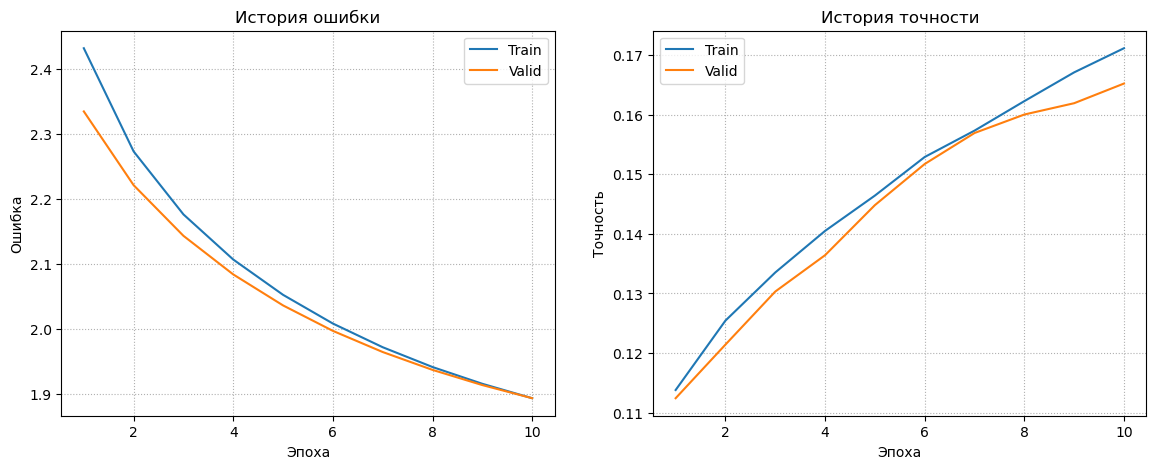

In [24]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

#### 4. Расчёт общей и классовой точности модели на тестовых данных

In [25]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model.eval()
vecs, labels = test_dataloader.__next__()
out = model.forward(vecs)

loss = hinge_loss(out, labels)
test_loss = loss.item()

pred_labels = np.argmax(out.array, axis=-1)
test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 1.8827
Точность на тесте: 0.1692


In [26]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.22      0.30      0.26      1000
           1       0.14      0.18      0.16      1000
           2       0.17      0.18      0.17      1000
           3       0.13      0.10      0.11      1000
           4       0.13      0.09      0.11      1000
           5       0.14      0.15      0.15      1000
           6       0.15      0.17      0.16      1000
           7       0.13      0.08      0.10      1000
           8       0.19      0.24      0.21      1000
           9       0.25      0.19      0.22      1000

    accuracy                           0.17     10000
   macro avg       0.17      0.17      0.17     10000
weighted avg       0.17      0.17      0.17     10000



#### 5. Вывод:
Проверка градиентов показала совпадение численного и аналитического градиента в пределах погрешности, что подтверждает их правильно реализованный расчёт с помощью метода обратного распространения ошибки.  
  
Графики точности и ошибки в процессе обучения модели продемонстрировали стабильное улучшение её качества на протяжении всех эпох: уменьшение значений функции ошибки сопровождалось ростом общей точности нейронной сети, при этом точности на тренировочной и валидационной выборке изменялись симметрично. Следовательно, для задачи была написана подходящая функция ошибки, и нейронная сеть не перешла на стадию переобучения.  
  
Из анализа классовой точности на тестовом наборе данных можно заметить, что обучение на большей части меток произведено равномерно. Особенно высокие результаты (выше 16% точности) можно выделить у классов: 0 - airplane, 2 - bird, 8 - ship, 9 - truck. При этом на всех классах точность оказалась выше 12%, а значение общей точности достигло 17% - что означает, что модель работает лучше случайного выбора метки.  
  
В последующих экспериментах будем считать данную модель с ReLU функцией активации и обычным градиентным спуском **базовой** и сравнивать метрики качества всех новых архитектур с её показателями.

### Эксперимент 2 Построение нейронной сети с Sigmoid функцией активации

Реализуйте эксперимент, доработав соответсвующее модули Numpy_NN фреймворка. Количество слоев, функций на ваше усмотрение. Можно добавлять любые другие функции активации на ваше усмотрение, но указанная в эксперименте функция должна быть обязательно. Перед обучением проверьте с помощью utils.gradient_check градиент вашей модели.

#### 1. Соберём две версии модели с помощью написанных инструментов: для проверки градиентов и обучения

In [27]:
np.random.seed(42)
# Для проверки градиентов
exam_model = Sequential(
    Linear(3072, 20),
    Sigmoid(),
    Linear(20, 10),
    Sigmoid(),
    Linear(10, 10)
)
print("Для проверки градиентов:\n", exam_model)
# Для обучения
model = Sequential(
    Linear(3072, 768),
    Sigmoid(),
    Linear(768, 128),
    Sigmoid(),
    Linear(128, 10)
)
print("Для обучения:\n", model)

Для проверки градиентов:
 Sequential(
	Linear(3072, 20, bias=True),
	Sigmoid(),
	Linear(20, 10, bias=True),
	Sigmoid(),
	Linear(10, 10, bias=True)
)
Для обучения:
 Sequential(
	Linear(3072, 768, bias=True),
	Sigmoid(),
	Linear(768, 128, bias=True),
	Sigmoid(),
	Linear(128, 10, bias=True)
)


#### 2. Проверим градиенты модели:

In [28]:
test_x, test_y = Dataloader(train_data, batch_size=2).__next__()
print(f"Градиенты модели считаются{' не' if not gradient_check(test_x, test_y, exam_model) else ''} правильно")

Градиенты модели считаются правильно                                                    


#### 3. Обучим нейронную сеть и визуализируем изменяющиеся в процессе обучения метрики

In [29]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data,
    model=model,
    epochs=10,
    optim_method="GD",
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000)

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  1.8640  | 0.1000  |  1.7656  | 0.0999  | 0.125610 |   3.2    |   3.2    |
| 2/10|  1.7074  | 0.1019  |  1.6153  | 0.1009  | 0.059801 |   3.1    |   6.3    |
| 3/10|  1.5691  | 0.1042  |  1.5063  | 0.1132  | 0.033313 |   3.2    |   9.5    |
| 4/10|  1.4818  | 0.1053  |  1.4482  | 0.1155  | 0.020476 |   3.1    |   12.6   |
| 5/10|  1.4329  | 0.1085  |  1.4100  | 0.1139  | 0.015194 |   3.1    |   15.7   |
| 6/10|  1.3980  | 0.1108  |  1.3796  | 0.1162  | 0.012750 |   3.2    |   18.9   |
| 7/10|  1.3693  | 0.1145  |  1.3539  | 0.1181  | 0.010899 |   3.2    |   22.1   |
| 8/10|  1.3448  | 0.1189  |  1.3318  | 0.1187  | 0.009696 |   3.2    |   25.2   |
| 9/10|  1.3237  | 0.1223  |  1.3127  | 0.1202  | 0.008418 |   3.2    |   28.4   |
|10/10|  1.3054  | 0.1253  |  1.2960  | 0.1232  | 0.007690 |   3.1    |   31.6   |


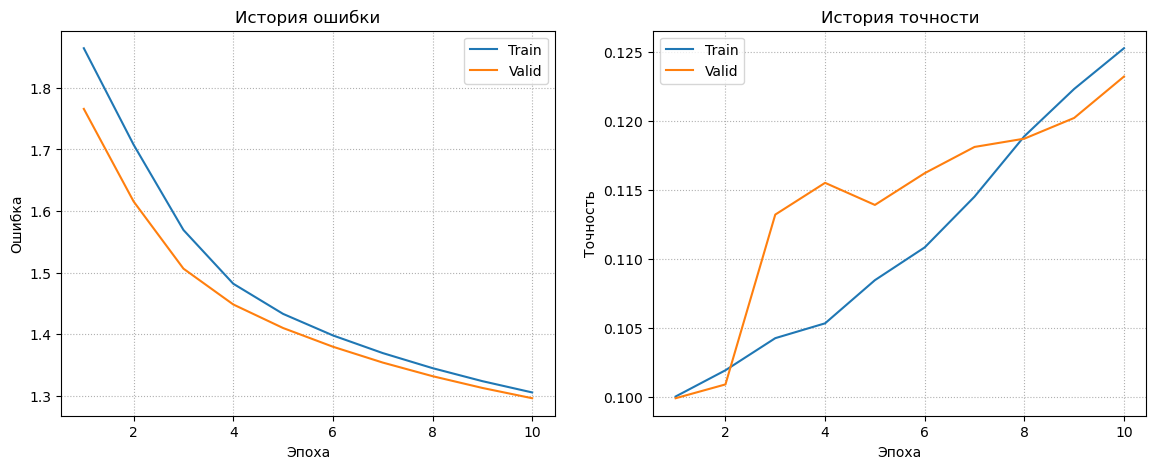

In [30]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

#### 4. Расчёт общей и классовой точности модели на тестовых данных

In [31]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model.eval()
vecs, labels = test_dataloader.__next__()
out = model.forward(vecs)

loss = hinge_loss(out, labels)
test_loss = loss.item()

pred_labels = np.argmax(out.array, axis=-1)
test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 1.2954
Точность на тесте: 0.1223


In [32]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.13      0.23      0.17      1000
           1       0.16      0.18      0.17      1000
           2       0.12      0.21      0.15      1000
           3       0.00      0.00      0.00      1000
           4       0.00      0.00      0.00      1000
           5       0.13      0.20      0.16      1000
           6       0.10      0.18      0.13      1000
           7       0.00      0.00      0.00      1000
           8       0.11      0.20      0.14      1000
           9       0.10      0.02      0.03      1000

    accuracy                           0.12     10000
   macro avg       0.08      0.12      0.09     10000
weighted avg       0.08      0.12      0.09     10000



/home/dmitryindenbom/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dmitryindenbom/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dmitryindenbom/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### 5. Вывод:
Проверка градиентов показала совпадение численного и аналитического градиента в пределах погрешности, что подтверждает их правильно реализованный расчёт с помощью метода обратного распространения ошибки.  
  
Графики точности и ошибки в процессе обучения модели продемонстрировали стабильное улучшение её качества на протяжении всех эпох: уменьшение значений функции ошибки сопровождалось ростом общей точности нейронной сети, при этом точности на тренировочной и валидационной выборке изменялись симметрично. Следовательно, для задачи была написана подходящая функция ошибки, и нейронная сеть не перешла на стадию переобучения.  
  
Из анализа классовой точности на тестовом наборе данных можно заметить, что обучение было произведено неравномерно. Предсказание некоторых классов было произведено с нулевой точностью: 3 - cat, 4 - deer, 7 - horse. Однако значение общей точности достигло 12% - что означает, что модель всё равно работает лучше случайного выбора метки.  
  
Сравнение с базовой моделью демонстрирует ухудшение качества нейронной сети при использовании сигмоиды в качестве функции активации. На это могло повлиять характерное для сигмоиды затухание градиентов при больших по модулю входных значениях, что привело бы к консервации части весов нейронной сети. При этом $L_2$ норма относительных градиентов (Grad/W) для сигмоиды совпадала с аналогичной у ReLU, что с учётом общего затухания градиентов (их уменьшения в 4 раза от каждого использования функции активации) в случае первой может указывать на остановке весов на слишком низких абсолютных значениях.

### Эксперимент 3 Построение нейронной сети с TanH функцией активации

Реализуйте эксперимент, доработав соответсвующие модули Numpy_NN фреймворка. Количество слоев, функций на ваше усмотрение. Можно добавлять любые другие функции активации на ваше усмотрение, но указанная в эксперименте функция должна быть обязательно. Перед обучением проверьте с помощью utils.gradient_check градиент вашей модели.   

#### 1. Соберём две версии модели с помощью написанных инструментов: для проверки градиентов и обучения

In [33]:
np.random.seed(42)
# Для проверки градиентов
exam_model = Sequential(
    Linear(3072, 20),
    Tanh(),
    Linear(20, 10),
    Tanh(),
    Linear(10, 10)
)
print("Для проверки градиентов:\n", exam_model)
# Для обучения
model = Sequential(
    Linear(3072, 768),
    Tanh(),
    Linear(768, 128),
    Tanh(),
    Linear(128, 10)
)
print("Для обучения:\n", model)

Для проверки градиентов:
 Sequential(
	Linear(3072, 20, bias=True),
	Tanh(),
	Linear(20, 10, bias=True),
	Tanh(),
	Linear(10, 10, bias=True)
)
Для обучения:
 Sequential(
	Linear(3072, 768, bias=True),
	Tanh(),
	Linear(768, 128, bias=True),
	Tanh(),
	Linear(128, 10, bias=True)
)


#### 2. Проверим градиенты модели:

In [34]:
test_x, test_y = Dataloader(train_data, batch_size=2).__next__()
print(f"Градиенты модели считаются{' не' if not gradient_check(test_x, test_y, exam_model) else ''} правильно")

Градиенты модели считаются правильно                                                    


#### 3. Обучим нейронную сеть и визуализируем изменяющиеся в процессе обучения метрики

In [35]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data,
    model=model,
    epochs=10,
    optim_method="GD",
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000)

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  2.0611  | 0.1243  |  2.0064  | 0.1264  | 0.122798 |   3.8    |   3.8    |
| 2/10|  1.9758  | 0.1359  |  1.9395  | 0.1396  | 0.044905 |   3.8    |   7.5    |
| 3/10|  1.9178  | 0.1449  |  1.8930  | 0.1497  | 0.040821 |   3.7    |   11.3   |
| 4/10|  1.8764  | 0.1529  |  1.8583  | 0.1573  | 0.033657 |   3.8    |   15.0   |
| 5/10|  1.8448  | 0.1583  |  1.8310  | 0.1622  | 0.029450 |   3.8    |   18.8   |
| 6/10|  1.8195  | 0.1633  |  1.8088  | 0.1670  | 0.025321 |   3.8    |   22.6   |
| 7/10|  1.7986  | 0.1675  |  1.7901  | 0.1722  | 0.022003 |   3.8    |   26.4   |
| 8/10|  1.7808  | 0.1721  |  1.7739  | 0.1763  | 0.018509 |   3.8    |   30.2   |
| 9/10|  1.7653  | 0.1766  |  1.7596  | 0.1801  | 0.016583 |   3.8    |   33.9   |
|10/10|  1.7517  | 0.1805  |  1.7469  | 0.1838  | 0.015826 |   3.8    |   37.7   |


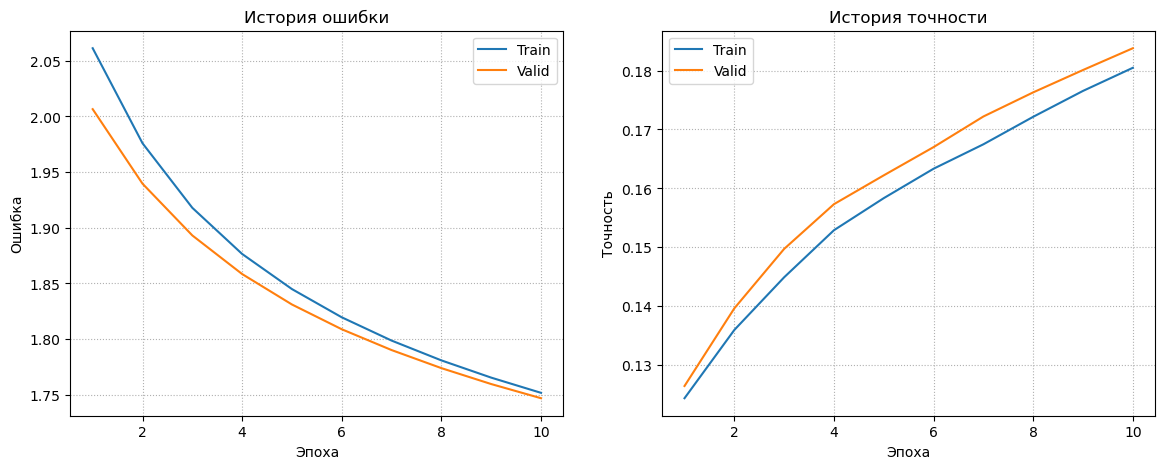

In [36]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

#### 4. Расчёт общей и классовой точности модели на тестовых данных

In [37]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model.eval()
vecs, labels = test_dataloader.__next__()
out = model.forward(vecs)

loss = hinge_loss(out, labels)
test_loss = loss.item()

pred_labels = np.argmax(out.array, axis=-1)
test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 1.7523
Точность на тесте: 0.1791


In [38]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.22      0.29      0.25      1000
           1       0.21      0.17      0.19      1000
           2       0.13      0.13      0.13      1000
           3       0.13      0.11      0.12      1000
           4       0.14      0.14      0.14      1000
           5       0.16      0.17      0.16      1000
           6       0.18      0.17      0.18      1000
           7       0.16      0.13      0.14      1000
           8       0.23      0.26      0.24      1000
           9       0.23      0.21      0.22      1000

    accuracy                           0.18     10000
   macro avg       0.18      0.18      0.18     10000
weighted avg       0.18      0.18      0.18     10000



#### 5. Вывод:
Проверка градиентов показала совпадение численного и аналитического градиента в пределах погрешности, что подтверждает их правильно реализованный расчёт с помощью метода обратного распространения ошибки.  
  
Графики точности и ошибки в процессе обучения модели продемонстрировали стабильное улучшение её качества на протяжении всех эпох: уменьшение значений функции ошибки сопровождалось ростом общей точности нейронной сети, при этом точности на тренировочной и валидационной выборке изменялись симметрично. Следовательно, для задачи была написана подходящая функция ошибки, и нейронная сеть не перешла на стадию переобучения.  
  
Из анализа классовой точности на тестовом наборе данных можно заметить, что обучение на большей части меток произведено равномерно. Особенно высокие результаты (выше 20% точности) можно выделить у классов: 0 - airplane, 1 - automobile, 8 - ship, 9 - truck. При этом на всех классах точность оказалась выше 12%, а значение общей точности достигло 18% - что означает, что модель работает лучше случайного выбора метки.  
  
Сравнение с базовой моделью демонстрирует небольшое улучшение качества нейронной сети при использовании гиперболического тангенса в качестве функции активации. С учётом более высокой нормы относительного градиента (Grad/W) у исследуемой архитектуры можно предположить, что улучшение связано с отсутствием зануления значений и градиентов функции активации для отрицательных входных признаков.

### Эксперимент 4 Построение нейронной сети с Dropout слоем

Реализуйте эксперимент, доработав соответсвующие модули Numpy_NN фреймворка. Количество слоев, функций на ваше усмотрение. Можно добавлять любые другие функции активации, слои на ваше усмотрение, но указанный в эксперименте слой должен быть обязательно. Перед обучением проверьте с помощью utils.gradient_check градиент вашей модели.  Подберите оптимальную вероятность в dropout. 

#### 1. Соберём две версии модели с помощью написанных инструментов: для проверки градиентов и обучения

In [39]:
np.random.seed(42)
# Для проверки градиентов
exam_model = Sequential(
    Linear(3072, 20),
    ReLU(),
    Dropout(p=0.1),
    Linear(20, 10),
    Dropout(p=0.1),
    ReLU(),
    Linear(10, 10)
)
print("Для проверки градиентов:\n", exam_model)
# Для обучения
model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Dropout(p=0.1),
    Linear(768, 128),
    ReLU(),
    Dropout(p=0.1),
    Linear(128, 10)
)
print("Для обучения:\n", model)

Для проверки градиентов:
 Sequential(
	Linear(3072, 20, bias=True),
	ReLU(),
	Dropout(p=0.1),
	Linear(20, 10, bias=True),
	Dropout(p=0.1),
	ReLU(),
	Linear(10, 10, bias=True)
)
Для обучения:
 Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	Dropout(p=0.1),
	Linear(768, 128, bias=True),
	ReLU(),
	Dropout(p=0.1),
	Linear(128, 10, bias=True)
)


#### 2. Проверим градиенты модели:

In [40]:
test_x, test_y = Dataloader(train_data, batch_size=2).__next__()
print(f"Градиенты модели считаются{' не' if not gradient_check(test_x, test_y, exam_model) else ''} правильно")

Градиенты модели считаются правильно                                                    


#### 3. Обучим нейронную сеть и визуализируем изменяющиеся в процессе обучения метрики

In [41]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data,
    model=model,
    epochs=10,
    optim_method="GD",
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000)

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  2.6991  | 0.1125  |  2.3538  | 0.1108  | 0.114623 |   3.3    |   3.3    |
| 2/10|  2.5721  | 0.1224  |  2.2403  | 0.1209  | 0.052472 |   3.3    |   6.6    |
| 3/10|  2.4796  | 0.1318  |  2.1603  | 0.1301  | 0.033378 |   3.4    |   10.0   |
| 4/10|  2.4021  | 0.1394  |  2.0993  | 0.1370  | 0.024630 |   3.4    |   13.4   |
| 5/10|  2.3530  | 0.1462  |  2.0503  | 0.1425  | 0.019473 |   3.4    |   16.7   |
| 6/10|  2.3071  | 0.1516  |  2.0098  | 0.1489  | 0.014928 |   3.3    |   20.0   |
| 7/10|  2.2688  | 0.1575  |  1.9756  | 0.1563  | 0.012513 |   3.4    |   23.4   |
| 8/10|  2.2345  | 0.1628  |  1.9468  | 0.1604  | 0.011048 |   3.4    |   26.8   |
| 9/10|  2.2109  | 0.1678  |  1.9219  | 0.1661  | 0.008879 |   3.4    |   30.1   |
|10/10|  2.1792  | 0.1726  |  1.9005  | 0.1701  | 0.008698 |   3.3    |   33.4   |


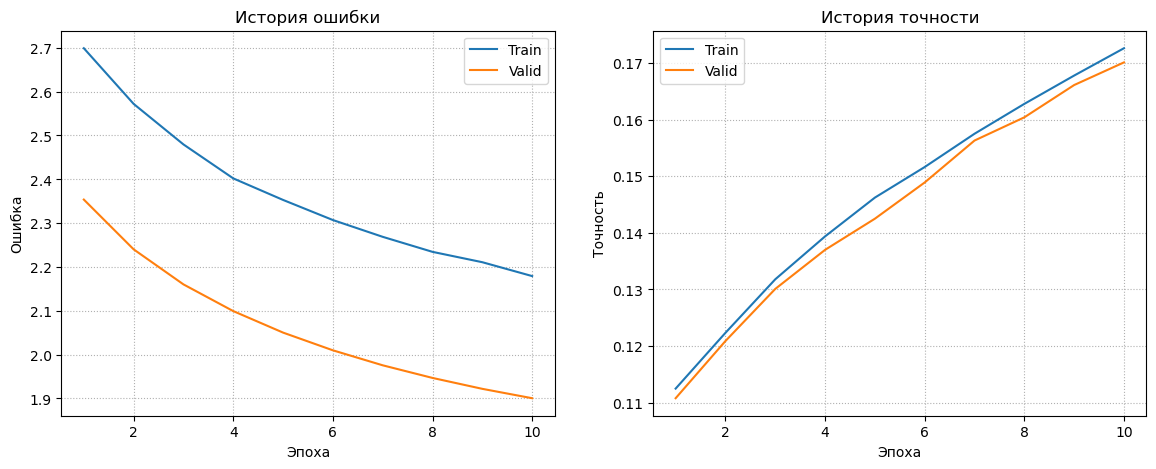

In [42]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

#### 4. Расчёт общей и классовой точности модели на тестовых данных

In [43]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model.eval()
vecs, labels = test_dataloader.__next__()
out = model.forward(vecs)

loss = hinge_loss(out, labels)
test_loss = loss.item()

pred_labels = np.argmax(out.array, axis=-1)
test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 1.8884
Точность на тесте: 0.1715


In [44]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.22      0.30      0.25      1000
           1       0.15      0.21      0.17      1000
           2       0.17      0.14      0.16      1000
           3       0.14      0.10      0.12      1000
           4       0.14      0.11      0.12      1000
           5       0.15      0.14      0.15      1000
           6       0.16      0.17      0.16      1000
           7       0.14      0.08      0.10      1000
           8       0.18      0.27      0.22      1000
           9       0.26      0.18      0.21      1000

    accuracy                           0.17     10000
   macro avg       0.17      0.17      0.17     10000
weighted avg       0.17      0.17      0.17     10000



#### 5. Вывод:
Проверка градиентов показала совпадение численного и аналитического градиента в пределах погрешности, что подтверждает их правильно реализованный расчёт с помощью метода обратного распространения ошибки.  
  
Графики точности и ошибки в процессе обучения модели продемонстрировали стабильное улучшение её качества на протяжении всех эпох: уменьшение значений функции ошибки сопровождалось ростом общей точности нейронной сети, при этом точности на тренировочной и валидационной выборке изменялись симметрично. Следовательно, для задачи была написана подходящая функция ошибки, и нейронная сеть не перешла на стадию переобучения.  
  
Из анализа классовой точности на тестовом наборе данных можно заметить, что обучение на большей части меток произведено равномерно. Особенно высокие результаты (выше 20% точности) можно выделить у классов: 0 - airplane, 9 - truck. При этом на всех классах точность оказалась выше 13%, а значение общей точности достигло 17% - что означает, что модель работает лучше случайного выбора метки.  

Сравнение с базовой моделью демонстрирует небольшое улучшение точности для отдельных классов и падение общей точности для всех меток при использовании Dropout слоя. Изменения точностей незначительны и могут являться погрешностью, более явный результат применения Dropout слоя должен быть заметен на большем количестве нейронов в 8-ом эксперименте.

### Эксперимент 5 Построение нейронной сети с Batchnorm слоем

Реализуйте эксперимент, доработав соответсвующие модули Numpy_NN фреймворка. Количество слоев, функций на ваше усмотрение. Можно добавлять любые другие функции активации, слои на ваше усмотрение, но указанный в эксперименте слой должен быть обязательно. Перед обучением проверьте с помощью utils.gradient_check градиент вашей модели.   

#### 1. Соберём две версии модели с помощью написанных инструментов: для проверки градиентов и обучения

In [45]:
np.random.seed(42)
# Для проверки градиентов
exam_model = Sequential(
    Linear(3072, 20),
    ReLU(),
    BatchNorm(20),
    Linear(20, 10),
    ReLU(),
    BatchNorm(10),
    Linear(10, 10)
)
print("Для проверки градиентов:\n", exam_model)
# Для обучения
model = Sequential(
    Linear(3072, 768),
    ReLU(),
    BatchNorm(768),
    Linear(768, 128),
    ReLU(),
    BatchNorm(128),
    Linear(128, 10)
)
print("Для обучения:\n", model)

Для проверки градиентов:
 Sequential(
	Linear(3072, 20, bias=True),
	ReLU(),
	BatchNorm(in_dim=20, eps=1e-05),
	Linear(20, 10, bias=True),
	ReLU(),
	BatchNorm(in_dim=10, eps=1e-05),
	Linear(10, 10, bias=True)
)
Для обучения:
 Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	BatchNorm(in_dim=768, eps=1e-05),
	Linear(768, 128, bias=True),
	ReLU(),
	BatchNorm(in_dim=128, eps=1e-05),
	Linear(128, 10, bias=True)
)


#### 2. Проверим градиенты модели:

In [46]:
test_x, test_y = Dataloader(train_data, batch_size=2).__next__()
print(f"Градиенты модели считаются{' не' if not gradient_check(test_x, test_y, exam_model) else ''} правильно")

Градиенты модели считаются правильно                                                    


#### 3. Обучим нейронную сеть и визуализируем изменяющиеся в процессе обучения метрики

In [47]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data,
    model=model,
    epochs=10,
    optim_method="GD",
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000)

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  1.2423  | 0.1032  |  1.9151  | 0.1003  | 0.129305 |   3.8    |   3.8    |
| 2/10|  1.2398  | 0.1081  |  1.4783  | 0.1042  | 0.064206 |   3.8    |   7.7    |
| 3/10|  1.2374  | 0.1142  |  1.3494  | 0.1090  | 0.042892 |   3.8    |   11.5   |
| 4/10|  1.2350  | 0.1178  |  1.2949  | 0.1135  | 0.031578 |   3.9    |   15.4   |
| 5/10|  1.2327  | 0.1210  |  1.2675  | 0.1170  | 0.025101 |   3.8    |   19.2   |
| 6/10|  1.2305  | 0.1234  |  1.2520  | 0.1218  | 0.020500 |   3.8    |   23.0   |
| 7/10|  1.2283  | 0.1252  |  1.2425  | 0.1228  | 0.017719 |   3.9    |   26.9   |
| 8/10|  1.2262  | 0.1269  |  1.2361  | 0.1242  | 0.015397 |   3.8    |   30.7   |
| 9/10|  1.2241  | 0.1284  |  1.2315  | 0.1265  | 0.013302 |   3.8    |   34.5   |
|10/10|  1.2222  | 0.1299  |  1.2279  | 0.1283  | 0.011661 |   3.9    |   38.4   |


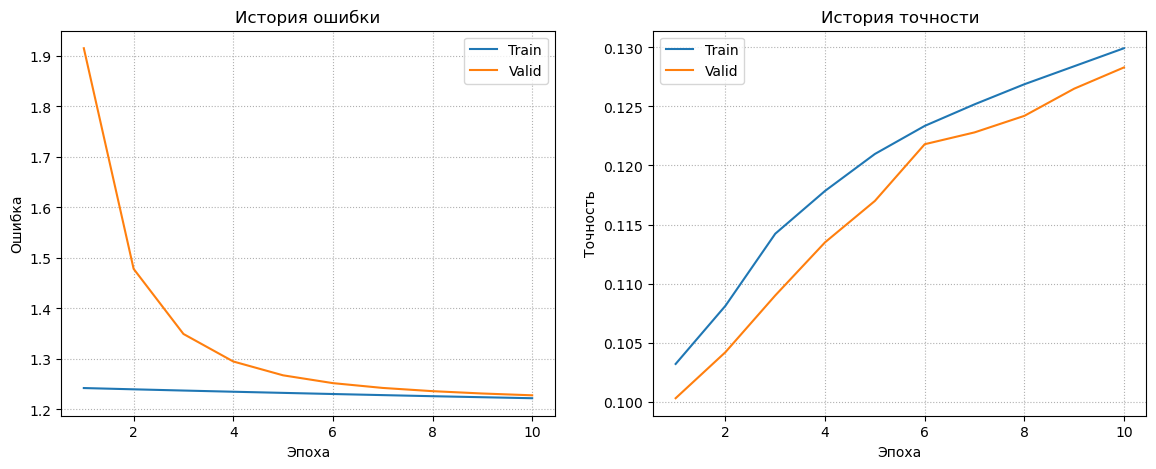

In [48]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

#### 4. Расчёт общей и классовой точности модели на тестовых данных

In [49]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model.eval()
vecs, labels = test_dataloader.__next__()
out = model.forward(vecs)

loss = hinge_loss(out, labels)
test_loss = loss.item()

pred_labels = np.argmax(out.array, axis=-1)
test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 1.2217
Точность на тесте: 0.1301


In [50]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.08      0.06      0.07      1000
           1       0.13      0.11      0.12      1000
           2       0.13      0.18      0.15      1000
           3       0.15      0.15      0.15      1000
           4       0.18      0.23      0.20      1000
           5       0.11      0.12      0.11      1000
           6       0.10      0.10      0.10      1000
           7       0.08      0.04      0.06      1000
           8       0.17      0.21      0.18      1000
           9       0.12      0.09      0.10      1000

    accuracy                           0.13     10000
   macro avg       0.12      0.13      0.13     10000
weighted avg       0.12      0.13      0.13     10000



#### 5. Вывод:
Проверка градиентов показала совпадение численного и аналитического градиента в пределах погрешности, что подтверждает их правильно реализованный расчёт с помощью метода обратного распространения ошибки.  
  
Графики точности и ошибки в процессе обучения модели продемонстрировали стабильное улучшение её качества на протяжении всех эпох: уменьшение значений функции ошибки сопровождалось ростом общей точности нейронной сети, при этом точности на тренировочной и валидационной выборке изменялись симметрично. Следовательно, для задачи была написана подходящая функция ошибки, и нейронная сеть не перешла на стадию переобучения. Расхождение значений Hinge Loss при обучении и тестировании объясняется изменением принципа работы Batch Normalisation при смене режима запуска.   
  
Из анализа классовой точности на тестовом наборе данных можно заметить, что обучение на большей части меток произведено равномерно. Особенно высокие результаты (выше 14% точности) можно выделить у классов: 3 - cat, 4 - deer, 8 - ship. При этом на всех классах точность оказалась выше или равна 8%, а значение общей точности достигло 13% - что означает, что модель работает лучше случайного выбора метки.   
  
Сравнение с базовой моделью демонстрирует падение точности работы нейронной сети при использовании Batch Norm слоя. Ухудшение может быть связано с высокой $L_2$ нормой относительных градиентов (Grad/W), из-за которой обычный градиентный спуск не попадает в оптимальные значения весов.

### Эксперимент 6 Эксперимент с Adam оптимизатором 

Обучите вашу нейронную сеть с Adam оптимизатором. Подбор гиперпараметров на ваше усмотрение. Перед обучением проверьте с помощью utils.gradient_check градиент вашей модели.   

#### 1. Соберём три версии модели с помощью написанных инструментов: для проверки градиентов и обучения нейронной сети без и с BatchNorm

In [51]:
np.random.seed(42)
# Для проверки градиентов
exam_model = Sequential(
    Linear(3072, 20),
    ReLU(),
    Linear(20, 10),
    ReLU(),
    Linear(10, 10)
)
print("Для проверки градиентов:\n", exam_model)
# Для обучения
model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Linear(768, 128),
    ReLU(),
    Linear(128, 10)
)
print("Для обучения:\n", model)
# Для обучения с Batch Norm слоем
batch_norm_model = Sequential(
    Linear(3072, 768),
    ReLU(),
    BatchNorm(768),
    Linear(768, 128),
    ReLU(),
    BatchNorm(128),
    Linear(128, 10)
)
print("Для обучения с Batch Norm слоем:\n", batch_norm_model)

Для проверки градиентов:
 Sequential(
	Linear(3072, 20, bias=True),
	ReLU(),
	Linear(20, 10, bias=True),
	ReLU(),
	Linear(10, 10, bias=True)
)
Для обучения:
 Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	Linear(768, 128, bias=True),
	ReLU(),
	Linear(128, 10, bias=True)
)
Для обучения с Batch Norm слоем:
 Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	BatchNorm(in_dim=768, eps=1e-05),
	Linear(768, 128, bias=True),
	ReLU(),
	BatchNorm(in_dim=128, eps=1e-05),
	Linear(128, 10, bias=True)
)


#### 2. Проверим градиенты модели:

In [52]:
test_x, test_y = Dataloader(train_data, batch_size=2).__next__()
print(f"Градиенты модели считаются{' не' if not gradient_check(test_x, test_y, exam_model) else ''} правильно")

Градиенты модели считаются правильно                                                    


#### 3. Обучим нейронную сеть и визуализируем изменяющиеся в процессе обучения метрики

##### Без Batch Normalisation

In [53]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data,
    model=model,
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000)

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  3.7860  | 0.2231  |  3.6470  | 0.2178  | 0.008114 |   3.0    |   3.0    |
| 2/10|  2.9488  | 0.2947  |  2.2291  | 0.2933  | 0.004873 |   3.0    |   6.0    |
| 3/10|  2.1964  | 0.3121  |  1.9525  | 0.3039  | 0.005623 |   3.0    |   9.1    |
| 4/10|  1.8061  | 0.3209  |  1.6644  | 0.3075  | 0.003018 |   3.1    |   12.1   |
| 5/10|  1.5246  | 0.3327  |  1.4614  | 0.3159  | 0.002976 |   3.0    |   15.2   |
| 6/10|  1.3835  | 0.3412  |  1.3165  | 0.3256  | 0.002929 |   3.2    |   18.4   |
| 7/10|  1.2492  | 0.3579  |  1.2468  | 0.3355  | 0.001815 |   3.1    |   21.5   |
| 8/10|  1.1933  | 0.3745  |  1.1957  | 0.3524  | 0.001476 |   3.0    |   24.5   |
| 9/10|  1.1439  | 0.3795  |  1.1526  | 0.3475  | 0.001493 |   3.0    |   27.5   |
|10/10|  1.0952  | 0.3745  |  1.1058  | 0.3473  | 0.001062 |   3.0    |   30.5   |


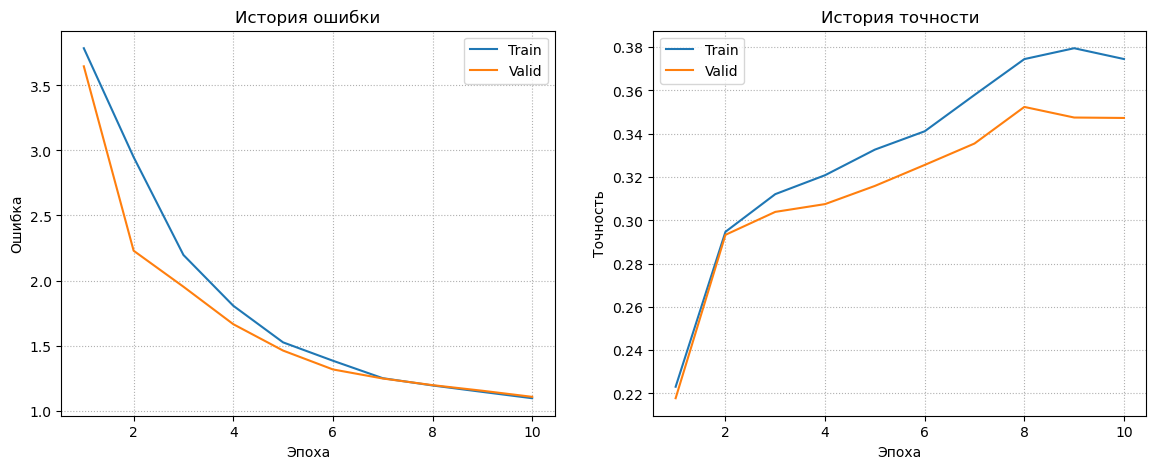

In [54]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

##### С Batch Normalisation

In [55]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data,
    model=batch_norm_model,
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000)

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  1.1718  | 0.2787  |  1.6515  | 0.2766  | 0.001332 |   3.9    |   3.9    |
| 2/10|  1.0534  | 0.3135  |  1.1910  | 0.3105  | 0.000637 |   4.0    |   7.9    |
| 3/10|  1.0262  | 0.3313  |  1.0850  | 0.3247  | 0.000686 |   3.9    |   11.8   |
| 4/10|  1.0138  | 0.3553  |  1.0520  | 0.3479  | 0.000430 |   3.9    |   15.7   |
| 5/10|  1.0066  | 0.3735  |  1.0302  | 0.3584  | 0.000393 |   3.9    |   19.6   |
| 6/10|  1.0005  | 0.4076  |  1.0129  | 0.3936  | 0.000412 |   3.9    |   23.5   |
| 7/10|  0.9951  | 0.4276  |  1.0036  | 0.4077  | 0.000386 |   3.8    |   27.4   |
| 8/10|  0.9900  | 0.4400  |  0.9983  | 0.4138  | 0.000546 |   3.9    |   31.3   |
| 9/10|  0.9844  | 0.4459  |  0.9935  | 0.4201  | 0.000353 |   3.9    |   35.2   |
|10/10|  0.9781  | 0.4547  |  0.9889  | 0.4223  | 0.000511 |   3.9    |   39.1   |


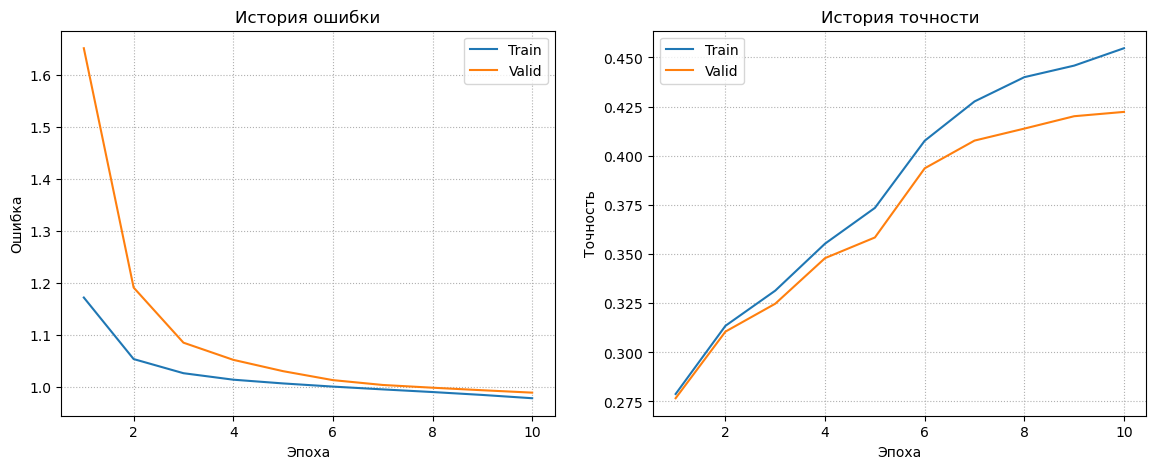

In [56]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

#### 4. Расчёт общей и классовой точности модели на тестовых данных

##### Без Batch Normalization

In [57]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model.eval()
vecs, labels = test_dataloader.__next__()
out = model.forward(vecs)

loss = hinge_loss(out, labels)
test_loss = loss.item()

pred_labels = np.argmax(out.array, axis=-1)
test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 1.1059
Точность на тесте: 0.3513


In [58]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.47      0.43      0.45      1000
           1       0.44      0.35      0.39      1000
           2       0.19      0.26      0.22      1000
           3       0.20      0.18      0.19      1000
           4       0.25      0.22      0.23      1000
           5       0.31      0.35      0.33      1000
           6       0.39      0.39      0.39      1000
           7       0.44      0.37      0.40      1000
           8       0.50      0.52      0.51      1000
           9       0.38      0.44      0.41      1000

    accuracy                           0.35     10000
   macro avg       0.36      0.35      0.35     10000
weighted avg       0.36      0.35      0.35     10000



##### C Batch Normalization

In [59]:
test_dataloader = Dataloader(test_data, len(test_data), False)
batch_norm_model.eval()
vecs, labels = test_dataloader.__next__()
out = batch_norm_model.forward(vecs)

loss = hinge_loss(out, labels)
test_loss = loss.item()

pred_labels = np.argmax(out.array, axis=-1)
test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 0.9871
Точность на тесте: 0.4339


In [60]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.53      0.50      0.52      1000
           1       0.61      0.49      0.55      1000
           2       0.37      0.19      0.25      1000
           3       0.30      0.15      0.20      1000
           4       0.31      0.46      0.37      1000
           5       0.40      0.34      0.37      1000
           6       0.42      0.50      0.46      1000
           7       0.41      0.57      0.48      1000
           8       0.52      0.64      0.57      1000
           9       0.45      0.51      0.48      1000

    accuracy                           0.43     10000
   macro avg       0.43      0.43      0.42     10000
weighted avg       0.43      0.43      0.42     10000



#### 5. Вывод:
Проверка градиентов показала совпадение численного и аналитического градиента в пределах погрешности, что подтверждает их правильно реализованный расчёт с помощью метода обратного распространения ошибки.  
  
Графики точности и ошибки в процессе обучения модели продемонстрировали стабильное улучшение её качества на протяжении всех эпох: уменьшение значений функции ошибки сопровождалось ростом общей точности нейронной сети, при этом точности на тренировочной и валидационной выборке изменялись симметрично. Следовательно, для задачи была написана подходящая функция ошибки, и нейронная сеть не перешла на стадию переобучения.  
  
Из анализа классовой точности на тестовом наборе данных можно заметить, что обучение на большей части меток произведено равномерно. Значение общей точности без использования Batch Normalization достигло 35%, а использованием стандартизирующих слоёв $-$ 43%. Следовательно, обе модели работают лучше случайного выбора метки. При этом явно заметно преимущество модели с Batch Norm слоями, которые позволяют избежать вызванного функцией активации ReLU взрыва градиентов, что подтверждается $L_2$ нормой их относительных значений.
  
Сравнение с базовой моделью из первого эксперимента демонстрирует значительное повышение качества работы нейронной сети при использовании оптимизатора AdamW для обучения, что и следовало ожидать.   
Для следующих экспериментов возьмём последнюю модель с Batch Normalization и алгоритмом оптимизации AdamW в качестве **базовой**.

### Эксперимент 7 Эксперимент c количеством слоев

Зафиксируйте модель и начинайте добавлять слои. Как меняется качество модели?

#### 1. Соберём две версии модели с помощью написанных инструментов: с одним и двумя дополнительными слоями

In [61]:
np.random.seed(42)
small_model = batch_norm_model
middle_model = Sequential(
    Linear(3072, 768),
    ReLU(),
    BatchNorm(768),
    Linear(768, 128),
    ReLU(),
    BatchNorm(128),
    Linear(128, 128),
    ReLU(),
    BatchNorm(128),
    Linear(128, 10)
)
print("Средняя модель:\n", middle_model)
large_model = Sequential(
    Linear(3072, 768),
    ReLU(),
    BatchNorm(768),
    Linear(768, 128),
    ReLU(),
    BatchNorm(128),
    Linear(128, 128),
    ReLU(),
    BatchNorm(128),
    Linear(128, 128),
    ReLU(),
    BatchNorm(128),
    Linear(128, 10)
)
print("Большая модель:\n", large_model)

Средняя модель:
 Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	BatchNorm(in_dim=768, eps=1e-05),
	Linear(768, 128, bias=True),
	ReLU(),
	BatchNorm(in_dim=128, eps=1e-05),
	Linear(128, 128, bias=True),
	ReLU(),
	BatchNorm(in_dim=128, eps=1e-05),
	Linear(128, 10, bias=True)
)
Большая модель:
 Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	BatchNorm(in_dim=768, eps=1e-05),
	Linear(768, 128, bias=True),
	ReLU(),
	BatchNorm(in_dim=128, eps=1e-05),
	Linear(128, 128, bias=True),
	ReLU(),
	BatchNorm(in_dim=128, eps=1e-05),
	Linear(128, 128, bias=True),
	ReLU(),
	BatchNorm(in_dim=128, eps=1e-05),
	Linear(128, 10, bias=True)
)


#### 2. Обучим нейронную сеть и визуализируем изменяющиеся в процессе обучения метрики

##### Средняя модель

In [62]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data,
    model=middle_model,
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000)

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  1.1496  | 0.2776  |  1.9570  | 0.2708  | 0.000907 |   4.1    |   4.1    |
| 2/10|  1.0466  | 0.3369  |  1.2332  | 0.3231  | 0.000610 |   4.1    |   8.2    |
| 3/10|  1.0241  | 0.3589  |  1.0920  | 0.3459  | 0.000561 |   4.1    |   12.3   |
| 4/10|  1.0113  | 0.3752  |  1.0472  | 0.3584  | 0.000338 |   4.1    |   16.4   |
| 5/10|  1.0026  | 0.3931  |  1.0203  | 0.3803  | 0.000274 |   4.1    |   20.5   |
| 6/10|  0.9942  | 0.4071  |  1.0070  | 0.3907  | 0.000364 |   4.1    |   24.6   |
| 7/10|  0.9864  | 0.4163  |  0.9979  | 0.3968  | 0.000249 |   4.1    |   28.7   |
| 8/10|  0.9785  | 0.4223  |  0.9915  | 0.3990  | 0.000201 |   4.1    |   32.8   |
| 9/10|  0.9702  | 0.4392  |  0.9820  | 0.4123  | 0.000271 |   4.1    |   36.9   |
|10/10|  0.9609  | 0.4409  |  0.9783  | 0.4129  | 0.000271 |   4.1    |   41.0   |


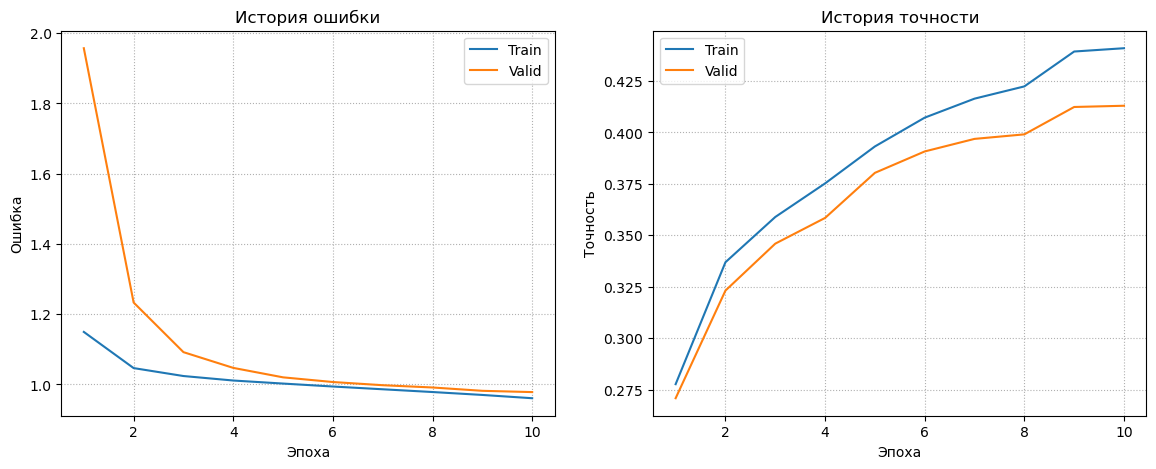

In [63]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

##### Большая модель

In [64]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data,
    model=large_model,
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000)

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  1.1352  | 0.2670  |  3.3283  | 0.2622  | 0.000739 |   4.3    |   4.3    |
| 2/10|  1.0479  | 0.2925  |  1.4350  | 0.2848  | 0.000540 |   4.3    |   8.6    |
| 3/10|  1.0252  | 0.3194  |  1.1518  | 0.3086  | 0.000380 |   4.3    |   12.9   |
| 4/10|  1.0108  | 0.3618  |  1.0557  | 0.3445  | 0.000436 |   4.3    |   17.2   |
| 5/10|  0.9986  | 0.3957  |  1.0179  | 0.3719  | 0.000529 |   4.3    |   21.5   |
| 6/10|  0.9875  | 0.4042  |  1.0016  | 0.3817  | 0.000260 |   4.3    |   25.8   |
| 7/10|  0.9768  | 0.4085  |  0.9904  | 0.3863  | 0.000268 |   4.3    |   30.1   |
| 8/10|  0.9655  | 0.4235  |  0.9798  | 0.3917  | 0.000313 |   4.3    |   34.4   |
| 9/10|  0.9524  | 0.4367  |  0.9705  | 0.3989  | 0.000351 |   4.2    |   38.7   |
|10/10|  0.9369  | 0.4437  |  0.9617  | 0.4059  | 0.000195 |   4.3    |   43.0   |


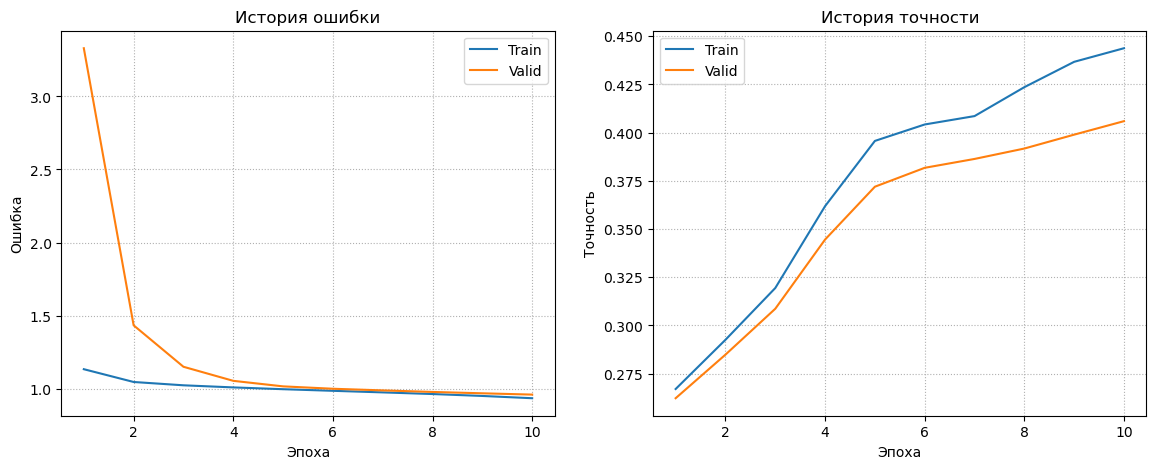

In [65]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

#### 3. Расчёт общей и классовой точности модели на тестовых данных

##### Средняя модель

In [66]:
test_dataloader = Dataloader(test_data, len(test_data), False)
middle_model.eval()
vecs, labels = test_dataloader.__next__()
out = middle_model.forward(vecs)

loss = hinge_loss(out, labels)
test_loss = loss.item()

pred_labels = np.argmax(out.array, axis=-1)
test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 0.9764
Точность на тесте: 0.4144


In [67]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.50      0.52      0.51      1000
           1       0.57      0.50      0.53      1000
           2       0.36      0.14      0.20      1000
           3       0.29      0.18      0.22      1000
           4       0.41      0.14      0.21      1000
           5       0.40      0.32      0.36      1000
           6       0.29      0.80      0.42      1000
           7       0.48      0.45      0.47      1000
           8       0.51      0.67      0.58      1000
           9       0.47      0.43      0.45      1000

    accuracy                           0.41     10000
   macro avg       0.43      0.41      0.39     10000
weighted avg       0.43      0.41      0.39     10000



##### Большая модель

In [68]:
test_dataloader = Dataloader(test_data, len(test_data), False)
large_model.eval()
vecs, labels = test_dataloader.__next__()
out = large_model.forward(vecs)

loss = hinge_loss(out, labels)
test_loss = loss.item()

pred_labels = np.argmax(out.array, axis=-1)
test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 0.9585
Точность на тесте: 0.4053


In [69]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.51      0.48      0.50      1000
           1       0.52      0.56      0.54      1000
           2       0.28      0.26      0.27      1000
           3       0.23      0.24      0.24      1000
           4       0.33      0.14      0.20      1000
           5       0.37      0.31      0.34      1000
           6       0.30      0.67      0.42      1000
           7       0.62      0.36      0.46      1000
           8       0.52      0.65      0.58      1000
           9       0.55      0.38      0.44      1000

    accuracy                           0.41     10000
   macro avg       0.42      0.41      0.40     10000
weighted avg       0.42      0.41      0.40     10000



#### 4. Вывод:
Графики точности и ошибки в процессе обучения модели продемонстрировали стабильное улучшение её качества на протяжении всех эпох: уменьшение значений функции ошибки сопровождалось ростом общей точности нейронной сети, при этом точности на тренировочной и валидационной выборке изменялись симметрично. Следовательно, для задачи была написана подходящая функция ошибки, и нейронная сеть не перешла на стадию переобучения.  
  
Из анализа классовой точности на тестовом наборе данных можно заметить, что обучение на большей части меток произведено относительно равномерно. Значение общей точности во всех случаях превисило 40%. Следовательно, все версии модели работают лучше случайного выбора метки. 
  
Сравнение с базовой версией модели из 6 эксперимента демонстрирует подаяние точности нейронной сети при увеличении количества слоёв. С учётом уменьшения $L_2$ нормы относительных градиентов (Grad/W) ухудшение качества нейронной сети, скорее всего, спровоцировано усилением затухания градиентов из-за исследуемого увеличения количества слоёв.

### Эксперимент 8 Эксперимент c количеством нейронов

Зафиксируйте модель и увеличьте количетсво весов в одном из слоев. Дает ли это прирост качества?

#### 1. Соберём три версии модели с помощью написанных инструментов: 
* Две с увеличенным вторым слоем до 256 и 512 выходных нейронов
* Одну с дополнительным Dropout слоем

In [70]:
np.random.seed(42)
small_model = batch_norm_model
middle_model = Sequential(
    Linear(3072, 768),
    ReLU(),
    BatchNorm(768),
    Linear(768, 256),
    ReLU(),
    BatchNorm(256),
    Linear(256, 10)
)
print("Средняя модель:\n", middle_model)
large_model = Sequential(
    Linear(3072, 768),
    ReLU(),
    BatchNorm(768),
    Linear(768, 512),
    ReLU(),
    BatchNorm(512),
    Linear(512, 10)
)
print("Большая модель:\n", large_model)
large_model_with_dropout = Sequential(
    Linear(3072, 768),
    ReLU(),
    Dropout(p=0.1),
    BatchNorm(768),
    Linear(768, 512),
    ReLU(),
    Dropout(p=0.1),
    BatchNorm(512),
    Linear(512, 10)
)
print("Большая модель с Dropout слоем:\n", large_model_with_dropout)

Средняя модель:
 Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	BatchNorm(in_dim=768, eps=1e-05),
	Linear(768, 256, bias=True),
	ReLU(),
	BatchNorm(in_dim=256, eps=1e-05),
	Linear(256, 10, bias=True)
)
Большая модель:
 Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	BatchNorm(in_dim=768, eps=1e-05),
	Linear(768, 512, bias=True),
	ReLU(),
	BatchNorm(in_dim=512, eps=1e-05),
	Linear(512, 10, bias=True)
)
Большая модель с Dropout слоем:
 Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	Dropout(p=0.1),
	BatchNorm(in_dim=768, eps=1e-05),
	Linear(768, 512, bias=True),
	ReLU(),
	Dropout(p=0.1),
	BatchNorm(in_dim=512, eps=1e-05),
	Linear(512, 10, bias=True)
)


#### 2. Обучим нейронную сеть и визуализируем изменяющиеся в процессе обучения метрики

##### Средняя модель

In [71]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data,
    model=middle_model,
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000)

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  1.1231  | 0.2946  |  1.3947  | 0.2865  | 0.002443 |   4.2    |   4.2    |
| 2/10|  1.0368  | 0.3552  |  1.0964  | 0.3432  | 0.001118 |   4.2    |   8.4    |
| 3/10|  1.0177  | 0.3761  |  1.0431  | 0.3603  | 0.000818 |   4.1    |   12.5   |
| 4/10|  1.0066  | 0.4057  |  1.0178  | 0.3867  | 0.000600 |   4.2    |   16.7   |
| 5/10|  0.9992  | 0.4137  |  1.0072  | 0.3910  | 0.000528 |   4.2    |   20.9   |
| 6/10|  0.9929  | 0.4400  |  0.9972  | 0.4131  | 0.000494 |   4.2    |   25.1   |
| 7/10|  0.9864  | 0.4463  |  0.9925  | 0.4186  | 0.000935 |   4.2    |   29.3   |
| 8/10|  0.9799  | 0.4618  |  0.9866  | 0.4337  | 0.000513 |   4.2    |   33.5   |
| 9/10|  0.9720  | 0.4716  |  0.9818  | 0.4377  | 0.000336 |   4.2    |   37.7   |
|10/10|  0.9629  | 0.4793  |  0.9763  | 0.4402  | 0.000378 |   4.2    |   41.9   |


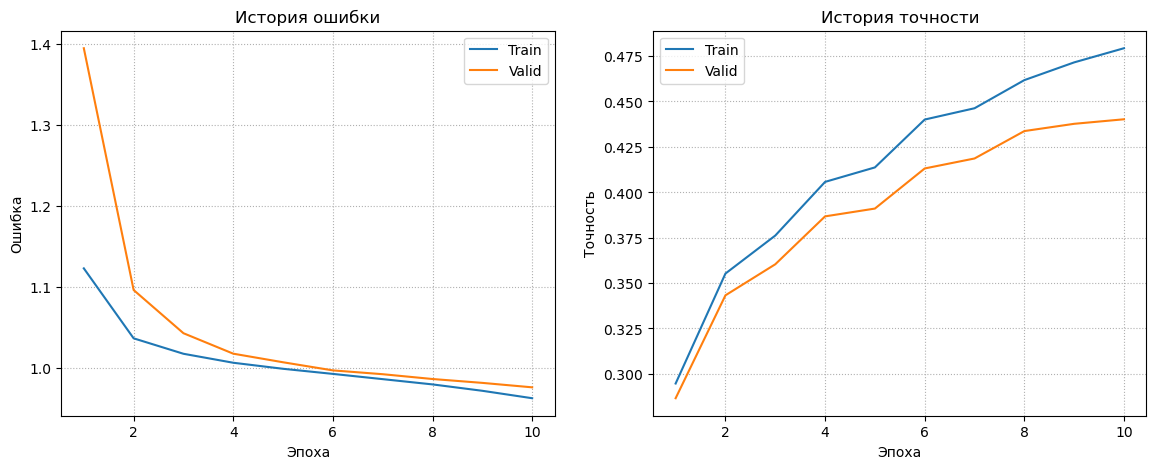

In [72]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

##### Большая модель

In [73]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data,
    model=large_model,
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000)

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  1.1030  | 0.3015  |  1.2827  | 0.2967  | 0.001507 |   4.9    |   4.9    |
| 2/10|  1.0322  | 0.3747  |  1.0552  | 0.3668  | 0.001538 |   4.8    |   9.7    |
| 3/10|  1.0128  | 0.3940  |  1.0283  | 0.3806  | 0.001041 |   4.9    |   14.6   |
| 4/10|  1.0034  | 0.4172  |  1.0092  | 0.3969  | 0.001094 |   4.8    |   19.4   |
| 5/10|  0.9964  | 0.4344  |  1.0018  | 0.4102  | 0.000922 |   4.8    |   24.2   |
| 6/10|  0.9902  | 0.4448  |  0.9945  | 0.4151  | 0.000861 |   4.9    |   29.1   |
| 7/10|  0.9840  | 0.4587  |  0.9887  | 0.4235  | 0.000856 |   4.8    |   33.9   |
| 8/10|  0.9767  | 0.4721  |  0.9833  | 0.4342  | 0.000575 |   4.9    |   38.8   |
| 9/10|  0.9686  | 0.4763  |  0.9779  | 0.4361  | 0.000437 |   4.9    |   43.7   |
|10/10|  0.9586  | 0.4915  |  0.9717  | 0.4450  | 0.000684 |   4.8    |   48.5   |


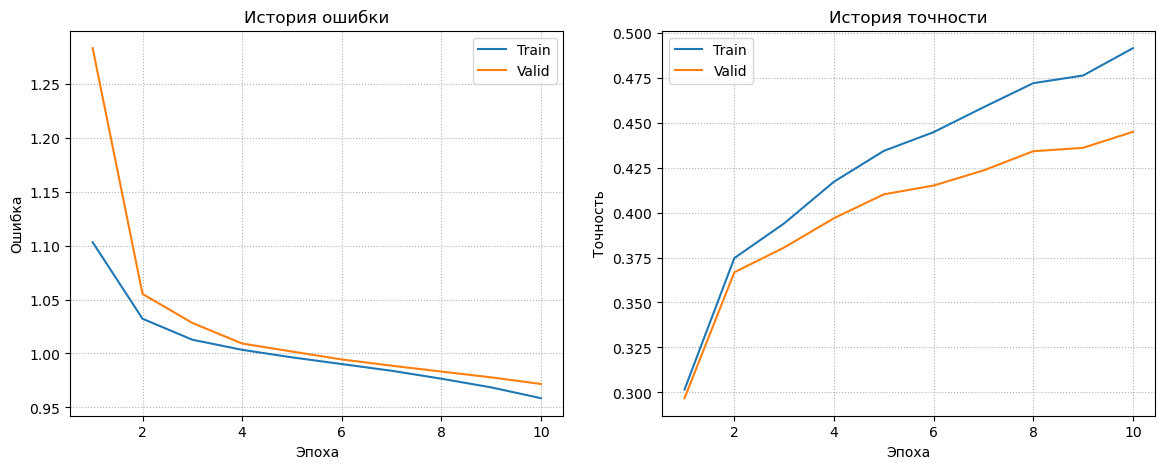

In [74]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

##### Большая модель с Dropout слоем

In [75]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data,
    model=large_model_with_dropout,
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000)

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  1.0962  | 0.3030  |  1.2392  | 0.2945  | 0.001832 |   5.4    |   5.4    |
| 2/10|  1.0383  | 0.3696  |  1.0673  | 0.3479  | 0.001339 |   5.3    |   10.7   |
| 3/10|  1.0234  | 0.3934  |  1.0272  | 0.3795  | 0.001554 |   5.3    |   16.0   |
| 4/10|  1.0148  | 0.4258  |  1.0088  | 0.4049  | 0.001567 |   5.3    |   21.3   |
| 5/10|  1.0078  | 0.4357  |  1.0000  | 0.4141  | 0.000966 |   5.4    |   26.7   |
| 6/10|  0.9997  | 0.4494  |  0.9935  | 0.4274  | 0.000901 |   5.4    |   32.2   |
| 7/10|  0.9919  | 0.4612  |  0.9869  | 0.4411  | 0.000858 |   5.3    |   37.5   |
| 8/10|  0.9836  | 0.4700  |  0.9806  | 0.4446  | 0.000705 |   5.4    |   42.9   |
| 9/10|  0.9739  | 0.4772  |  0.9741  | 0.4496  | 0.000656 |   5.4    |   48.2   |
|10/10|  0.9626  | 0.4828  |  0.9654  | 0.4507  | 0.000508 |   5.4    |   53.7   |


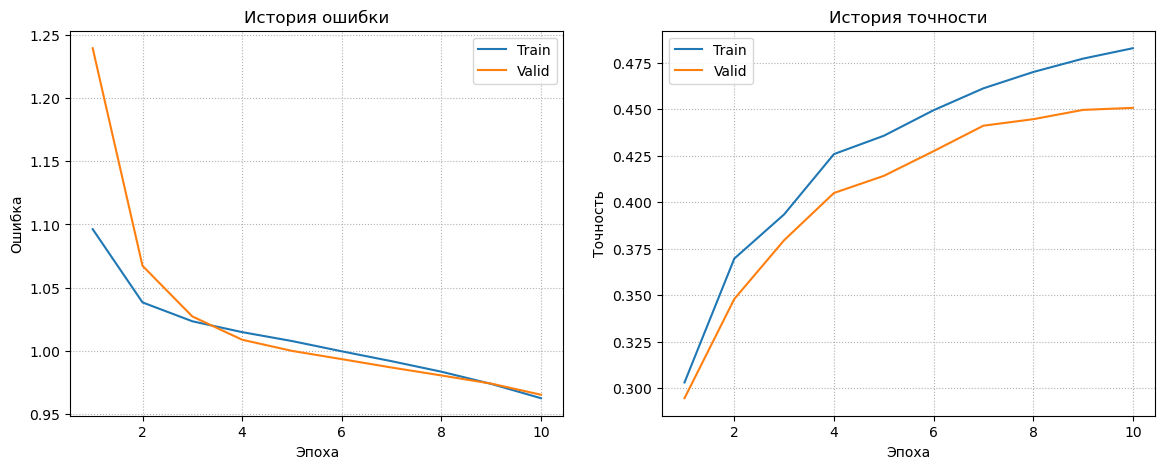

In [76]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

#### 3. Расчёт общей и классовой точности модели на тестовых данных

##### Средняя модель

In [77]:
test_dataloader = Dataloader(test_data, len(test_data), False)
middle_model.eval()
vecs, labels = test_dataloader.__next__()
out = middle_model.forward(vecs)

loss = hinge_loss(out, labels)
test_loss = loss.item()

pred_labels = np.argmax(out.array, axis=-1)
test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 0.9760
Точность на тесте: 0.4455


In [78]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.52      0.50      0.51      1000
           1       0.62      0.49      0.55      1000
           2       0.38      0.17      0.24      1000
           3       0.36      0.19      0.25      1000
           4       0.34      0.41      0.37      1000
           5       0.34      0.44      0.39      1000
           6       0.47      0.53      0.50      1000
           7       0.45      0.52      0.48      1000
           8       0.48      0.69      0.57      1000
           9       0.48      0.51      0.49      1000

    accuracy                           0.45     10000
   macro avg       0.44      0.45      0.43     10000
weighted avg       0.44      0.45      0.43     10000



##### Большая модель

In [79]:
test_dataloader = Dataloader(test_data, len(test_data), False)
large_model.eval()
vecs, labels = test_dataloader.__next__()
out = large_model.forward(vecs)

loss = hinge_loss(out, labels)
test_loss = loss.item()

pred_labels = np.argmax(out.array, axis=-1)
test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 0.9712
Точность на тесте: 0.4521


In [80]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.54      0.49      0.51      1000
           1       0.56      0.55      0.55      1000
           2       0.29      0.36      0.32      1000
           3       0.32      0.20      0.25      1000
           4       0.40      0.28      0.33      1000
           5       0.44      0.34      0.38      1000
           6       0.45      0.57      0.50      1000
           7       0.51      0.53      0.52      1000
           8       0.50      0.68      0.57      1000
           9       0.49      0.52      0.50      1000

    accuracy                           0.45     10000
   macro avg       0.45      0.45      0.44     10000
weighted avg       0.45      0.45      0.44     10000



##### Большая модель с Dropout слоем

In [81]:
test_dataloader = Dataloader(test_data, len(test_data), False)
large_model_with_dropout.eval()
vecs, labels = test_dataloader.__next__()
out = large_model_with_dropout.forward(vecs)

loss = hinge_loss(out, labels)
test_loss = loss.item()

pred_labels = np.argmax(out.array, axis=-1)
test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 0.9647
Точность на тесте: 0.4528


In [82]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.56      0.51      0.54      1000
           1       0.59      0.54      0.56      1000
           2       0.32      0.30      0.31      1000
           3       0.31      0.28      0.29      1000
           4       0.36      0.34      0.35      1000
           5       0.36      0.38      0.37      1000
           6       0.43      0.56      0.49      1000
           7       0.56      0.47      0.51      1000
           8       0.50      0.69      0.58      1000
           9       0.54      0.46      0.50      1000

    accuracy                           0.45     10000
   macro avg       0.45      0.45      0.45     10000
weighted avg       0.45      0.45      0.45     10000



#### 4. Вывод:
Графики точности и ошибки в процессе обучения модели продемонстрировали стабильное улучшение её качества на протяжении всех эпох: уменьшение значений функции ошибки сопровождалось ростом общей точности нейронной сети, при этом точности на тренировочной и валидационной выборке изменялись симметрично. Следовательно, для задачи была написана подходящая функция ошибки, и нейронная сеть не перешла на стадию переобучения даже с учётом увеличения количества весов.  
  
Из анализа классовой точности на тестовом наборе данных можно заметить, что обучение на большей части меток произведено относительно равномерно. Значение общей точности во всех случаях превысило 44%. Следовательно, все версии модели работают лучше случайного выбора метки.
  
Сравнение с базовой версией модели из 6 эксперимента демонстрирует улучшение точности нейронной сети при увеличении количества нейронов. Однако стоит помнить, что при слишком большом количестве весов нейронная сеть может начать переобучаться.
  
Стоит также отметить результаты модели с Dropout слоем: хотя повышение общей точности на тестовой выборке незначительно, оно произошло на фоне уменьшения точности на тренировочной выборке. Следовательно, использование Dropout слоя привело к ожидаемому улучшению обобщения закономерностей нейронной сетью. 

### Эксперимент 9 Эксперимент c размером батча

Зафиксируйте модель и обучитесь на разных размерах. Как размер батча влияет на процесс обучения?

#### 1. Соберём две модели, аналогичные базовой из 6-ого эксперимента

In [83]:
np.random.seed(42)
# Для обучения на 20000 записях
middle_model = Sequential(
    Linear(3072, 768),
    ReLU(),
    BatchNorm(768),
    Linear(768, 128),
    ReLU(),
    BatchNorm(128),
    Linear(128, 10)
)
print("Для обучения на 20000 записях:\n", model)
np.random.seed(42)
# Для обучения на 40000 записях
large_model = Sequential(
    Linear(3072, 768),
    ReLU(),
    BatchNorm(768),
    Linear(768, 128),
    ReLU(),
    BatchNorm(128),
    Linear(128, 10)
)
print("Для обучения на 40000 записях:\n", model)

Для обучения на 20000 записях:
 Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	Linear(768, 128, bias=True),
	ReLU(),
	Linear(128, 10, bias=True)
)
Для обучения на 40000 записях:
 Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	Linear(768, 128, bias=True),
	ReLU(),
	Linear(128, 10, bias=True)
)


#### 2. Обучим нейронную сеть и визуализируем изменяющиеся в процессе обучения метрики

##### С размером батча в 20000 записей

In [84]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data,
    model=middle_model,
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=20000)

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  1.2092  | 0.1986  |  2.8658  | 0.1955  | 0.005708 |   3.6    |   3.6    |
| 2/10|  1.0902  | 0.2541  |  1.5266  | 0.2458  | 0.001285 |   3.7    |   7.3    |
| 3/10|  1.0565  | 0.2912  |  1.2458  | 0.2847  | 0.001242 |   3.7    |   11.0   |
| 4/10|  1.0395  | 0.2989  |  1.1637  | 0.2920  | 0.000943 |   3.7    |   14.7   |
| 5/10|  1.0283  | 0.3103  |  1.1171  | 0.3064  | 0.000566 |   3.7    |   18.4   |
| 6/10|  1.0202  | 0.3276  |  1.0827  | 0.3239  | 0.000669 |   3.7    |   22.1   |
| 7/10|  1.0152  | 0.3442  |  1.0582  | 0.3358  | 0.000613 |   3.7    |   25.8   |
| 8/10|  1.0108  | 0.3586  |  1.0413  | 0.3499  | 0.000433 |   3.7    |   29.4   |
| 9/10|  1.0071  | 0.3765  |  1.0290  | 0.3601  | 0.000488 |   3.7    |   33.2   |
|10/10|  1.0036  | 0.3863  |  1.0216  | 0.3698  | 0.000407 |   3.7    |   36.8   |


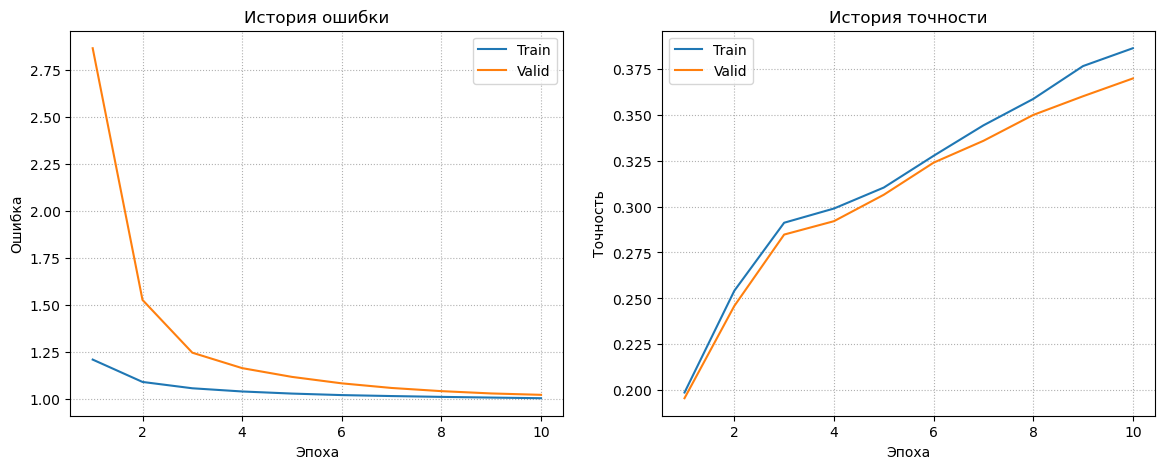

In [85]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

##### С размером батча в 40000 записей

In [86]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data,
    model=large_model,
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=40000)

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  1.2442  | 0.1689  |  8.3593  | 0.1721  | 0.004894 |   3.7    |   3.8    |
| 2/10|  1.1737  | 0.2041  |  2.8059  | 0.2003  | 0.005940 |   3.7    |   7.4    |
| 3/10|  1.1048  | 0.2309  |  1.8850  | 0.2238  | 0.002177 |   3.7    |   11.2   |
| 4/10|  1.0762  | 0.2555  |  1.5410  | 0.2496  | 0.001344 |   3.8    |   15.0   |
| 5/10|  1.0624  | 0.2726  |  1.3619  | 0.2654  | 0.001243 |   3.8    |   18.8   |
| 6/10|  1.0517  | 0.2880  |  1.2578  | 0.2847  | 0.001196 |   3.7    |   22.5   |
| 7/10|  1.0435  | 0.2963  |  1.2005  | 0.2906  | 0.001119 |   3.7    |   26.2   |
| 8/10|  1.0365  | 0.3006  |  1.1645  | 0.2917  | 0.000922 |   3.7    |   29.9   |
| 9/10|  1.0308  | 0.3078  |  1.1363  | 0.3013  | 0.000709 |   4.3    |   34.2   |
|10/10|  1.0262  | 0.3173  |  1.1138  | 0.3146  | 0.000563 |   3.8    |   38.0   |


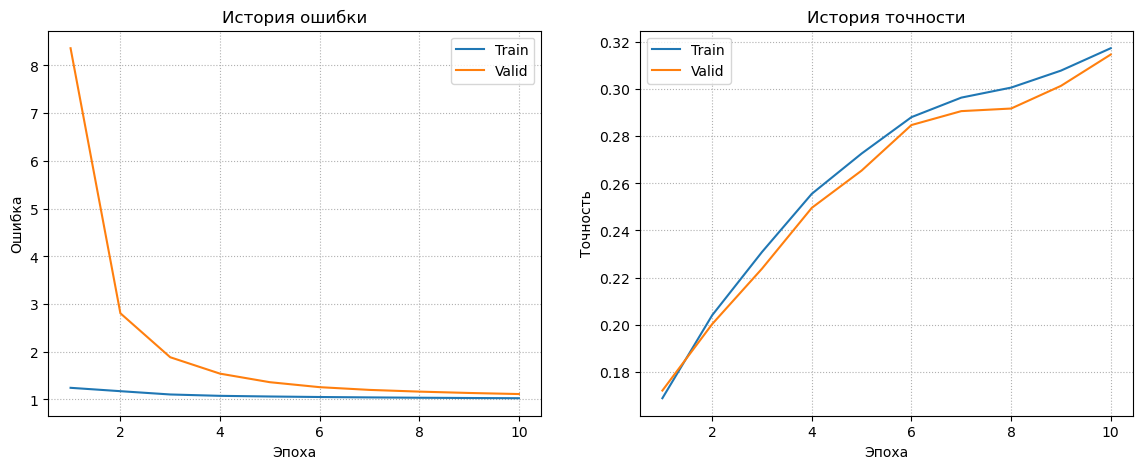

In [87]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                               train_acc_history, valid_acc_history)

#### 3. Расчёт общей и классовой точности модели на тестовых данных

##### С размером батча в 20000 записей

In [88]:
test_dataloader = Dataloader(test_data, len(test_data), False)
middle_model.eval()
vecs, labels = test_dataloader.__next__()
out = middle_model.forward(vecs)

loss = hinge_loss(out, labels)
test_loss = loss.item()

pred_labels = np.argmax(out.array, axis=-1)
test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 1.0209
Точность на тесте: 0.3689


In [89]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.42      0.54      0.47      1000
           1       0.51      0.43      0.47      1000
           2       0.36      0.10      0.16      1000
           3       0.20      0.41      0.27      1000
           4       0.42      0.04      0.07      1000
           5       0.31      0.37      0.34      1000
           6       0.37      0.37      0.37      1000
           7       0.33      0.47      0.39      1000
           8       0.58      0.47      0.52      1000
           9       0.47      0.48      0.47      1000

    accuracy                           0.37     10000
   macro avg       0.40      0.37      0.35     10000
weighted avg       0.40      0.37      0.35     10000



##### С размером батча в 40000 записей

In [90]:
test_dataloader = Dataloader(test_data, len(test_data), False)
large_model.eval()
vecs, labels = test_dataloader.__next__()
out = large_model.forward(vecs)

loss = hinge_loss(out, labels)
test_loss = loss.item()

pred_labels = np.argmax(out.array, axis=-1)
test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 1.1100
Точность на тесте: 0.3141


In [91]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.35      0.58      0.44      1000
           1       0.49      0.27      0.35      1000
           2       0.38      0.06      0.10      1000
           3       0.18      0.61      0.28      1000
           4       0.32      0.02      0.04      1000
           5       0.23      0.19      0.21      1000
           6       0.36      0.21      0.27      1000
           7       0.31      0.42      0.36      1000
           8       0.65      0.33      0.43      1000
           9       0.47      0.44      0.45      1000

    accuracy                           0.31     10000
   macro avg       0.38      0.31      0.29     10000
weighted avg       0.38      0.31      0.29     10000



#### 4. Вывод:
Графики точности и ошибки в процессе обучения модели продемонстрировали стабильное улучшение её качества на протяжении всех эпох: уменьшение значений функции ошибки сопровождалось ростом общей точности нейронной сети, при этом точности на тренировочной и валидационной выборке изменялись симметрично. Следовательно, для задачи была написана подходящая функция ошибки, и нейронная сеть не перешла на стадию переобучения.  
  
Из анализа классовой точности на тестовом наборе данных можно заметить, что обучение на большей части меток произведено относительно равномерно. Значение общей точности во всех случаях превысило 30%. Следовательно, все версии модели работают лучше случайного выбора метки.
  
Сравнение с базовой версией модели из 6 эксперимента демонстрирует подаяние точности нейронной сети при увеличении размера батча как на тренировочной, так и на тестовой выборке.

### Эксперимент 10 Эксперимент с регуляризацией

Добавьте в процесс обучения L1/L2 регуляризацию. Повлияло ли это на качество? Выведите норму весов без регуляризации и с. 

#### 1. Соберём две модели, аналогичные базовой из 6-ого эксперимента

In [92]:
np.random.seed(42)
# Для обучения с L_1 регуляризацией
l1_model = Sequential(
    Linear(3072, 768),
    ReLU(),
    BatchNorm(768),
    Linear(768, 128),
    ReLU(),
    BatchNorm(128),
    Linear(128, 10)
)
print("Для обучения с L_1 регуляризацией:\n", l1_model)
np.random.seed(42)
# Для обучения с L_2 регуляризацией
l2_model = Sequential(
    Linear(3072, 768),
    ReLU(),
    BatchNorm(768),
    Linear(768, 128),
    ReLU(),
    BatchNorm(128),
    Linear(128, 10)
)
print("Для обучения с L_2 регуляризацией:\n", l2_model)
np.random.seed(42)
# Для обучения с L_2 и L_1 регуляризацией
l2_l1_model = Sequential(
    Linear(3072, 768),
    ReLU(),
    BatchNorm(768),
    Linear(768, 128),
    ReLU(),
    BatchNorm(128),
    Linear(128, 10)
)
print("Для обучения с L_2 и L_1 регуляризацией:\n", l2_l1_model)

Для обучения с L_1 регуляризацией:
 Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	BatchNorm(in_dim=768, eps=1e-05),
	Linear(768, 128, bias=True),
	ReLU(),
	BatchNorm(in_dim=128, eps=1e-05),
	Linear(128, 10, bias=True)
)
Для обучения с L_2 регуляризацией:
 Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	BatchNorm(in_dim=768, eps=1e-05),
	Linear(768, 128, bias=True),
	ReLU(),
	BatchNorm(in_dim=128, eps=1e-05),
	Linear(128, 10, bias=True)
)
Для обучения с L_2 и L_1 регуляризацией:
 Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	BatchNorm(in_dim=768, eps=1e-05),
	Linear(768, 128, bias=True),
	ReLU(),
	BatchNorm(in_dim=128, eps=1e-05),
	Linear(128, 10, bias=True)
)


#### 2. Обучим нейронную сеть и визуализируем изменяющиеся в процессе обучения метрики

##### C $L_1$ регуляризацией

In [93]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data,
    model=l1_model,
    epochs=10,
    lr=0.001,
    alpha1=0.01,
    valid_dataset=valid_data,
    batch_size=10000)

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  1.1527  | 0.2536  |  1.5432  | 0.2455  | 0.001254 |   4.0    |   4.0    |
| 2/10|  1.0493  | 0.2945  |  1.1674  | 0.2894  | 0.000840 |   4.0    |   7.9    |
| 3/10|  1.0251  | 0.3231  |  1.0867  | 0.3205  | 0.000602 |   3.9    |   11.9   |
| 4/10|  1.0132  | 0.3519  |  1.0425  | 0.3395  | 0.000496 |   4.0    |   15.8   |
| 5/10|  1.0061  | 0.3857  |  1.0211  | 0.3681  | 0.000477 |   4.1    |   19.9   |
| 6/10|  0.9996  | 0.4035  |  1.0100  | 0.3866  | 0.000348 |   3.9    |   23.8   |
| 7/10|  0.9942  | 0.4132  |  1.0025  | 0.3975  | 0.000341 |   4.0    |   27.8   |
| 8/10|  0.9884  | 0.4240  |  0.9969  | 0.4042  | 0.000308 |   3.9    |   31.7   |
| 9/10|  0.9828  | 0.4367  |  0.9924  | 0.4097  | 0.000504 |   3.9    |   35.7   |
|10/10|  0.9766  | 0.4549  |  0.9864  | 0.4224  | 0.000521 |   4.0    |   39.7   |


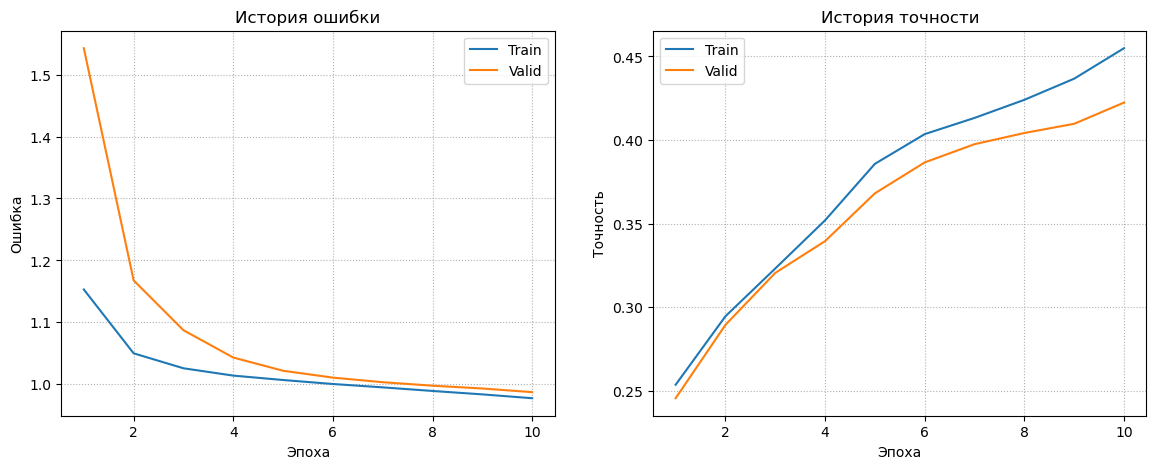

In [94]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

##### C $L_2$ регуляризацией

In [95]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data,
    model=l2_model,
    epochs=10,
    lr=0.001,
    alpha2=0.01,
    valid_dataset=valid_data,
    batch_size=10000)

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  1.1495  | 0.2503  |  1.5414  | 0.2448  | 0.001598 |   4.0    |   4.0    |
| 2/10|  1.0485  | 0.2868  |  1.1809  | 0.2787  | 0.000906 |   3.9    |   7.9    |
| 3/10|  1.0245  | 0.3254  |  1.0876  | 0.3198  | 0.000634 |   3.9    |   11.8   |
| 4/10|  1.0136  | 0.3504  |  1.0455  | 0.3413  | 0.000537 |   3.9    |   15.7   |
| 5/10|  1.0065  | 0.3661  |  1.0271  | 0.3543  | 0.000408 |   3.9    |   19.6   |
| 6/10|  1.0001  | 0.3911  |  1.0143  | 0.3749  | 0.000269 |   3.9    |   23.6   |
| 7/10|  0.9945  | 0.4061  |  1.0048  | 0.3887  | 0.000401 |   4.0    |   27.5   |
| 8/10|  0.9887  | 0.4138  |  0.9992  | 0.3884  | 0.000415 |   3.9    |   31.5   |
| 9/10|  0.9833  | 0.4329  |  0.9928  | 0.4037  | 0.000362 |   4.0    |   35.4   |
|10/10|  0.9773  | 0.4469  |  0.9879  | 0.4164  | 0.000398 |   3.9    |   39.4   |


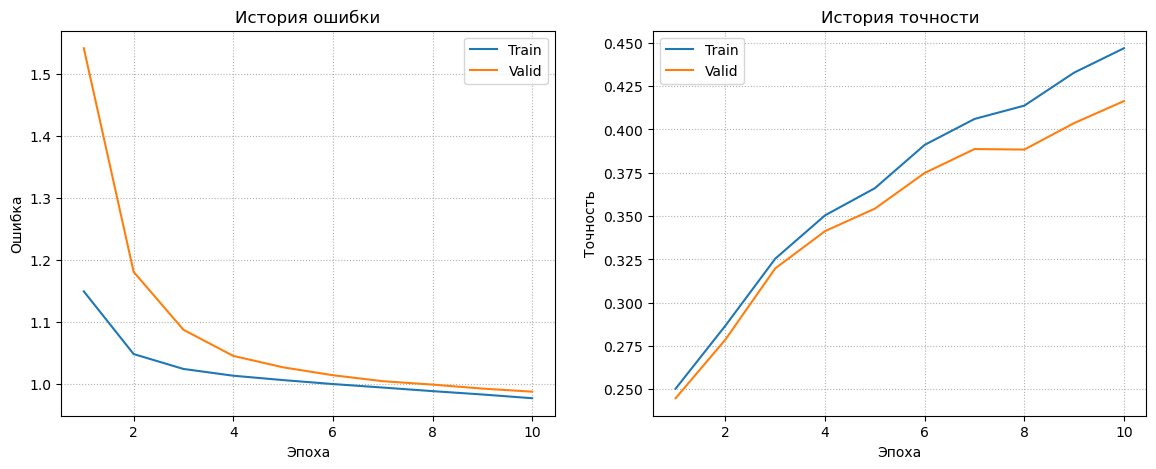

In [96]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

##### C $L_2$ и $L_1$ регуляризациями

In [97]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data,
    model=l2_l1_model,
    epochs=10,
    lr=0.001,
    alpha1=0.01,
    alpha2=0.01,
    valid_dataset=valid_data,
    batch_size=1000)

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  1.0364  | 0.4105  |  1.0053  | 0.3881  | 0.001575 |   5.1    |   5.1    |
| 2/10|  0.9891  | 0.4478  |  0.9847  | 0.4185  | 0.001170 |   5.1    |   10.3   |
| 3/10|  0.9627  | 0.4834  |  0.9611  | 0.4420  | 0.000597 |   5.2    |   15.4   |
| 4/10|  0.9261  | 0.5039  |  0.9359  | 0.4567  | 0.000654 |   5.2    |   20.6   |
| 5/10|  0.8922  | 0.5306  |  0.9258  | 0.4687  | 0.000525 |   5.1    |   25.7   |
| 6/10|  0.8610  | 0.5486  |  0.9123  | 0.4806  | 0.000411 |   5.2    |   30.9   |
| 7/10|  0.8343  | 0.5742  |  0.9121  | 0.4874  | 0.000550 |   5.2    |   36.0   |
| 8/10|  0.8036  | 0.5844  |  0.9056  | 0.4906  | 0.000412 |   5.1    |   41.2   |
| 9/10|  0.7775  | 0.5943  |  0.9088  | 0.4925  | 0.000563 |   5.2    |   46.3   |
|10/10|  0.7526  | 0.6159  |  0.8996  | 0.4972  | 0.000504 |   5.2    |   51.5   |


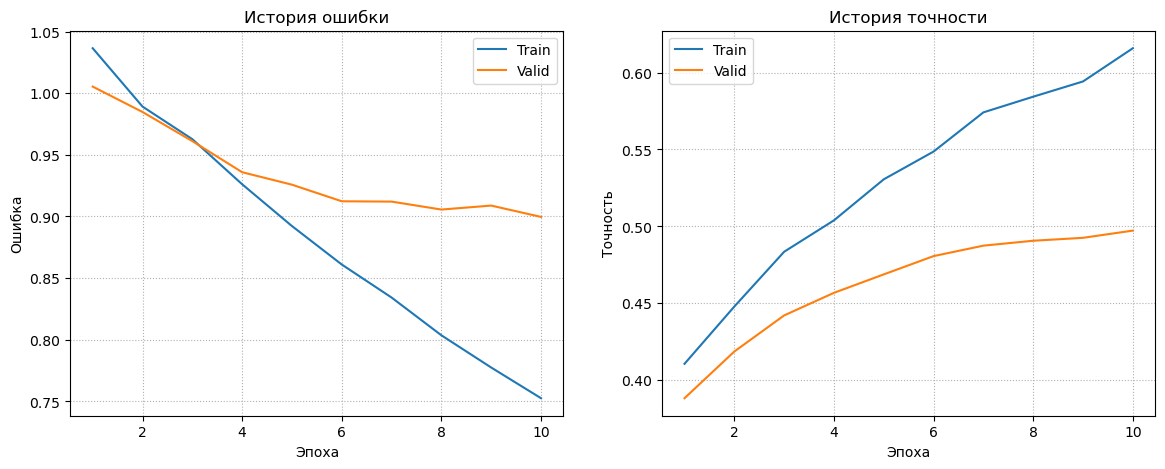

In [98]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                               train_acc_history, valid_acc_history)

#### 3. Расчёт общей и классовой точности модели на тестовых данных

##### C $L_1$ регуляризацией

In [99]:
test_dataloader = Dataloader(test_data, len(test_data), False)
l1_model.eval()
vecs, labels = test_dataloader.__next__()
out = l1_model.forward(vecs)

loss = hinge_loss(out, labels)
test_loss = loss.item()

pred_labels = np.argmax(out.array, axis=-1)
test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 0.9866
Точность на тесте: 0.4214


In [100]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.51      0.48      0.49      1000
           1       0.56      0.53      0.54      1000
           2       0.36      0.21      0.27      1000
           3       0.24      0.31      0.27      1000
           4       0.49      0.12      0.19      1000
           5       0.32      0.41      0.36      1000
           6       0.43      0.49      0.46      1000
           7       0.43      0.49      0.46      1000
           8       0.55      0.61      0.58      1000
           9       0.44      0.56      0.49      1000

    accuracy                           0.42     10000
   macro avg       0.43      0.42      0.41     10000
weighted avg       0.43      0.42      0.41     10000



##### C $L_2$ регуляризацией

In [101]:
test_dataloader = Dataloader(test_data, len(test_data), False)
l2_model.eval()
vecs, labels = test_dataloader.__next__()
out = l2_model.forward(vecs)

loss = hinge_loss(out, labels)
test_loss = loss.item()

pred_labels = np.argmax(out.array, axis=-1)
test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 0.9878
Точность на тесте: 0.4250


In [102]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.51      0.50      0.51      1000
           1       0.58      0.51      0.55      1000
           2       0.39      0.12      0.19      1000
           3       0.26      0.35      0.30      1000
           4       0.47      0.11      0.18      1000
           5       0.35      0.41      0.37      1000
           6       0.37      0.60      0.46      1000
           7       0.44      0.48      0.46      1000
           8       0.56      0.60      0.58      1000
           9       0.44      0.56      0.49      1000

    accuracy                           0.42     10000
   macro avg       0.44      0.42      0.41     10000
weighted avg       0.44      0.42      0.41     10000



##### C $L_2$ и $L_1$ регуляризациями

In [103]:
test_dataloader = Dataloader(test_data, len(test_data), False)
l2_l1_model.eval()
vecs, labels = test_dataloader.__next__()
out = l2_l1_model.forward(vecs)

loss = hinge_loss(out, labels)
test_loss = loss.item()

pred_labels = np.argmax(out.array, axis=-1)
test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 0.8911
Точность на тесте: 0.5012


In [104]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.54      0.57      0.56      1000
           1       0.62      0.64      0.63      1000
           2       0.39      0.31      0.35      1000
           3       0.35      0.28      0.31      1000
           4       0.36      0.52      0.43      1000
           5       0.43      0.36      0.39      1000
           6       0.61      0.46      0.52      1000
           7       0.54      0.62      0.58      1000
           8       0.57      0.73      0.64      1000
           9       0.59      0.52      0.55      1000

    accuracy                           0.50     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       0.50      0.50      0.50     10000



#### 4. Посчитаем среднюю $L_2$ норму весов моделей

In [105]:
def get_weithts_linalg_norm(trained_model):
    num_params = 0
    scale = 0
    for param in trained_model.parameters():
        scale += np.linalg.norm(param.params.flatten())
        num_params += 1
    scale /= num_params
    return scale

In [106]:
print("Без регуляризации:", get_weithts_linalg_norm(batch_norm_model))
print("С L_1 регуляризацией:", get_weithts_linalg_norm(l1_model))
print("С L_2 регуляризацией:", get_weithts_linalg_norm(l2_model))
print("С L_1 и L_2  регуляризациями:", get_weithts_linalg_norm(l2_l1_model))

Без регуляризации: 5.379693241203086
С L_1 регуляризацией: 5.320537380195539
С L_2 регуляризацией: 5.37016976833888
С L_1 и L_2  регуляризациями: 6.092000416825499


#### 5. Вывод:
Графики точности и ошибки в процессе обучения моделей продемонстрировали стабильное улучшение её качества на протяжении всех эпох: уменьшение значений функции ошибки сопровождалось ростом общей точности нейронной сети, при этом точности на тренировочной и валидационной выборке изменялись симметрично. Следовательно, для задачи была написана подходящая функция ошибки, и нейронная сеть не перешла на стадию переобучения.  
  
Из анализа классовой точности на тестовом наборе данных можно заметить, что обучение на большей части меток произведено относительно равномерно. Значение общей точности во всех случаях превысило 41%. Следовательно, все версии модели работают лучше случайного выбора метки.
  
Сравнение с базовой версией модели из 6 эксперимента демонстрирует увеличение точности нейронной сети при использовании одновременно $L_2$ и $L_1$ регуляризаций. Стоит отметить, что использование только $L_2$ или $L_1$ регуляризации, напротив, повлияло на обучение нейронной сети в пределах погрешности.
  
Использование регуляризации следующим образом повлияло на $L_2$ норму весов:
* Без регуляризации: $|W|_2 = 5.38$
* С $L_1$ регуляризацией: $|W|_2 = 5.32$
* С $L_2$ регуляризацией: $|W|_2 = 5.37$
* С $L_1$ и $L_2$ регуляризациями: $|W|_2 = 6.09$

### Эксперимент 11 Финальная архитектура

Как выглядит ваша финальная модель?

* В качестве основы для финальной модели возьмём базовую нейроннную сесть из 6-ого эксперимента. 
* В каждом блоке модели увеличим количество весов и добавим Dropout слои для избежания переобучения и лучшего обобщения закономерностей. 
* Сравним две версии модели с функциями активации ReLU и Dropout.
* Уменьшим размер  батча в 10 раз.
* Воспользуемся AdamW оптимизацией, использующией $L_1$ и $L_2$ регуляризации с коэффициентом $\alpha_1 = \alpha_2 = 0.01$.
* Увеличим количество эпох до 20 и 30 для первой и второй версии модели, соответственно.

#### 1. Соберём две версии модели с помощью написанных инструментов

In [107]:
np.random.seed(42)
# Для обучения с ReLU функцией активации
relu_model = Sequential(
    Dropout(p=0.1),
    Linear(3072, 1024),
    ReLU(),
    Dropout(p=0.1),
    BatchNorm(1024),
    Linear(1024, 512),
    ReLU(),
    Dropout(p=0.1),
    BatchNorm(512),
    Linear(512, 10)
)
print("Для обучения с ReLU функцией активации:\n", relu_model)
np.random.seed(42)
# Для обучения с Tanh функцией активациии
tanh_model = Sequential(
    Dropout(p=0.1),
    Linear(3072, 1024),
    Tanh(),
    Dropout(p=0.1),
    BatchNorm(1024),
    Linear(1024, 512),
    Tanh(),
    Dropout(p=0.1),
    BatchNorm(512),
    Linear(512, 10)
)
print("Для обучения с Tanh функцией активациии:\n", tanh_model)

Для обучения с ReLU функцией активации:
 Sequential(
	Dropout(p=0.1),
	Linear(3072, 1024, bias=True),
	ReLU(),
	Dropout(p=0.1),
	BatchNorm(in_dim=1024, eps=1e-05),
	Linear(1024, 512, bias=True),
	ReLU(),
	Dropout(p=0.1),
	BatchNorm(in_dim=512, eps=1e-05),
	Linear(512, 10, bias=True)
)
Для обучения с Tanh функцией активациии:
 Sequential(
	Dropout(p=0.1),
	Linear(3072, 1024, bias=True),
	Tanh(),
	Dropout(p=0.1),
	BatchNorm(in_dim=1024, eps=1e-05),
	Linear(1024, 512, bias=True),
	Tanh(),
	Dropout(p=0.1),
	BatchNorm(in_dim=512, eps=1e-05),
	Linear(512, 10, bias=True)
)


#### 2. Обучим нейронную сеть и визуализируем изменяющиеся в процессе обучения метрики

##### Модель с ReLU функцией активации

In [108]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data,
    model=relu_model,
    epochs=20,
    lr=0.001,
    alpha1=0.01,
    alpha2=0.01,
    valid_dataset=valid_data,
    batch_size=1000)

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/20|  1.0279  | 0.4266  |  0.9926  | 0.4039  | 0.002059 |   9.6    |   9.6    |
| 2/20|  0.9795  | 0.4531  |  0.9621  | 0.4275  | 0.001472 |   9.5    |   19.2   |
| 3/20|  0.9410  | 0.4722  |  0.9395  | 0.4406  | 0.000585 |   9.5    |   28.7   |
| 4/20|  0.9121  | 0.4702  |  0.9269  | 0.4392  | 0.001115 |   9.5    |   38.2   |
| 5/20|  0.8851  | 0.5054  |  0.9086  | 0.4639  | 0.000835 |   9.5    |   47.6   |
| 6/20|  0.8649  | 0.5185  |  0.8950  | 0.4653  | 0.000621 |   9.4    |   57.1   |
| 7/20|  0.8373  | 0.5376  |  0.8805  | 0.4807  | 0.000495 |   9.5    |   66.6   |
| 8/20|  0.8163  | 0.5522  |  0.8820  | 0.4811  | 0.000711 |   9.5    |   76.1   |
| 9/20|  0.7984  | 0.5647  |  0.8787  | 0.4923  | 0.000767 |   9.4    |   85.5   |
|10/20|  0.7782  | 0.5784  |  0.8662  | 0.4937  | 0.000565 |   9.5    |   95.0   |
|11/

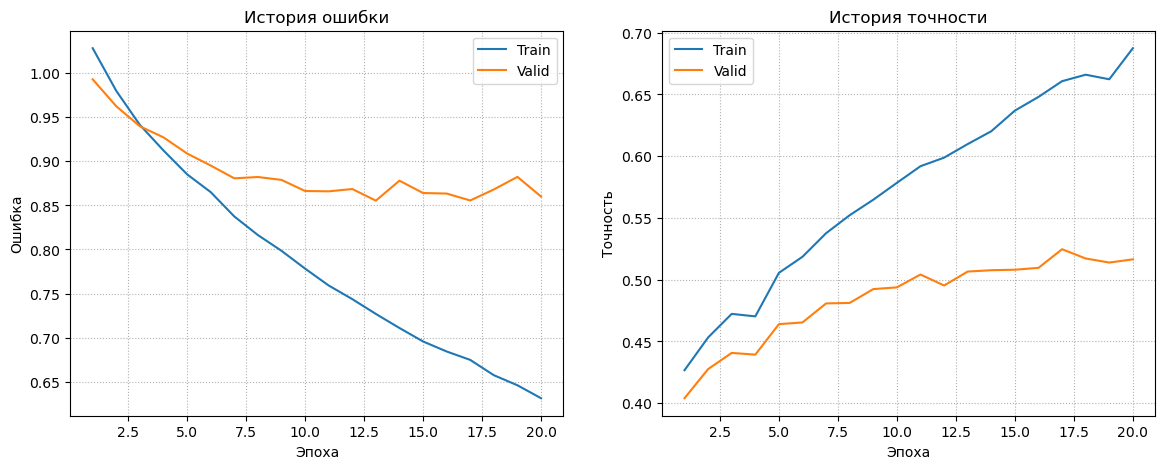

In [109]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

##### Модель с Tanh функцией активациии

In [110]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data,
    model=tanh_model,
    epochs=30,
    lr=0.00002,
    alpha1=0.01,
    alpha2=0.01,
    valid_dataset=valid_data,
    batch_size=1000)

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/30|  1.0811  | 0.2959  |  1.0402  | 0.2948  | 0.000138 |   10.6   |   10.6   |
| 2/30|  1.0526  | 0.3394  |  1.0283  | 0.3342  | 0.000056 |   10.6   |   21.3   |
| 3/30|  1.0443  | 0.3639  |  1.0230  | 0.3564  | 0.000062 |   10.7   |   32.0   |
| 4/30|  1.0387  | 0.3770  |  1.0198  | 0.3684  | 0.000050 |   11.0   |   42.9   |
| 5/30|  1.0351  | 0.3906  |  1.0172  | 0.3810  | 0.000047 |   10.6   |   53.6   |
| 6/30|  1.0324  | 0.4009  |  1.0149  | 0.3911  | 0.000050 |   10.6   |   64.1   |
| 7/30|  1.0298  | 0.4075  |  1.0134  | 0.3954  | 0.000039 |   10.6   |   74.7   |
| 8/30|  1.0270  | 0.4144  |  1.0122  | 0.3960  | 0.000047 |   10.6   |   85.3   |
| 9/30|  1.0258  | 0.4190  |  1.0108  | 0.3999  | 0.000030 |   10.6   |   95.9   |
|10/30|  1.0244  | 0.4250  |  1.0094  | 0.4018  | 0.000034 |   10.6   |  106.5   |
|11/

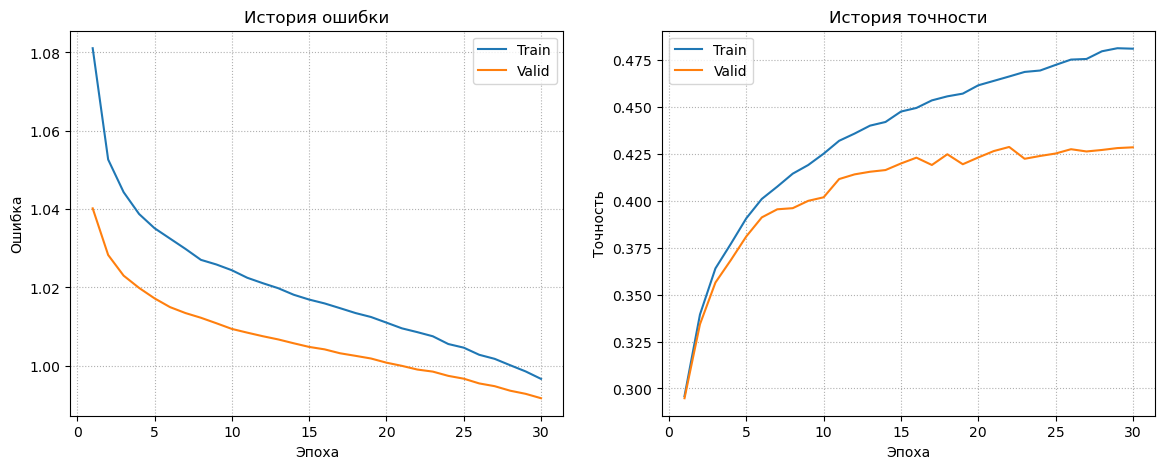

In [111]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

#### 3. Расчёт общей и классовой точности модели на тестовых данных

##### Модель с ReLU функцией активации

In [112]:
test_dataloader = Dataloader(test_data, len(test_data), False)
relu_model.eval()
vecs, labels = test_dataloader.__next__()
out = relu_model.forward(vecs)

loss = hinge_loss(out, labels)
test_loss = loss.item()

pred_labels = np.argmax(out.array, axis=-1)
test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 0.8494
Точность на тесте: 0.5237


In [113]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.60      0.62      0.61      1000
           1       0.62      0.71      0.66      1000
           2       0.31      0.44      0.36      1000
           3       0.35      0.37      0.36      1000
           4       0.51      0.33      0.40      1000
           5       0.50      0.34      0.41      1000
           6       0.53      0.60      0.56      1000
           7       0.63      0.57      0.60      1000
           8       0.70      0.64      0.67      1000
           9       0.59      0.61      0.60      1000

    accuracy                           0.52     10000
   macro avg       0.53      0.52      0.52     10000
weighted avg       0.53      0.52      0.52     10000



##### Модель с Tanh функцией активациии¶

In [114]:
test_dataloader = Dataloader(test_data, len(test_data), False)
tanh_model.eval()
vecs, labels = test_dataloader.__next__()
out = tanh_model.forward(vecs)

loss = hinge_loss(out, labels)
test_loss = loss.item()

pred_labels = np.argmax(out.array, axis=-1)
test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 0.9930
Точность на тесте: 0.4317


In [115]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.47      0.52      0.50      1000
           1       0.48      0.54      0.51      1000
           2       0.34      0.19      0.25      1000
           3       0.36      0.17      0.23      1000
           4       0.39      0.31      0.34      1000
           5       0.38      0.34      0.36      1000
           6       0.43      0.56      0.49      1000
           7       0.43      0.51      0.46      1000
           8       0.47      0.72      0.57      1000
           9       0.44      0.46      0.45      1000

    accuracy                           0.43     10000
   macro avg       0.42      0.43      0.42     10000
weighted avg       0.42      0.43      0.42     10000



#### 4. Вывод:
Графики точности и ошибки в процессе обучения модели продемонстрировали стабильное улучшение её качества на первых эпохах: уменьшение значений функции ошибки сопровождалось ростом общей точности нейронной сети, при этом точности на тренировочной и валидационной выборке изменялись симметрично. Но на последних 3-5 шагах увеличивалась только тренировочная точность, валидационнная же точность почти не изменялась. На версии модели с ReLU функцией активации точность на тренировочном наборе данных успела достигнуть 75%, в то время как на валидационном закрепилась на 52%. Следовательно, нейронная сеть в конце перешла на стадию переобучения, выучивая особенности тренировочной выборки вместо общих закономерностей.
  
Из анализа классовой точности на тестовом наборе данных можно заметить, что обучение с Tanh в качестве функции активации было произведено более равномерно. Но значение общей точности для версии модели с ReLU при меньшем количестве эпох оказалась выше: 52% против 43%. При этом для Tanh понадобилось уменьшить коэффициент скорости обучения до $lr = 0.00002$, так как при больших значениях модель переставала сходиться. Однако стоит отметить, что обе версии модели в итоге работают лучше случайного выбора метки. 
  
В итоге можно сказать, что версия нейронной сети с ReLU функцией активации оказалась наиболее эффективной, достигнув максимальной точности среди всех остальных моделей из предыдущих экспериментов.